# Model Tuning

This notebook includes a hyperparameter tuning and feature selection exercise for the top performing classifier. The objective is to narrow down which features and hyperparameters will be used in the next phase of scaling to jurisdictional scale maps.

* **Which features have the greatest influence in the predictions?**
    - CatBoost's feature importance method
    - Shap value analysis
* **Which features are correlated?**
    - Shap value analysis
* **Which hyperparameters should be used?**
    - Catboost's random search method
* **How does the resulting/tuned model compare with the baseline?**

Full conclusions are in separate notebook.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src/')
import ptype_prepare_data as pp
import ptype_run_preds as rp
import score_classifier as score
import ptype_visualize as viz
import pandas as pd
import pickle
from datetime import datetime
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import shap
shap.initjs()

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'matplotlib'

# Feature Analysis
Evaluate feature importance for the top performing MVP model (Catboost). Training with only the most important features will help to reduce overfitting and training time, while improving accuracy by removing misleading data and noise. Feature importance values are normalized so that the sum of importances of all features is equal to 100.   
  
Index `0`: slope  
Index `1:3`: s1  
Index `3:13`: s2  
Index `13:77`: TML features (`13` is TML tree probability)  
** _Note that in some sections of the notebook the TML features are presented with indices 0-64 and in others they are presented 13-77_

In [4]:
def feature_selection(model, feat_count):
    
    '''
    calculates the feature importance score for a given model
    returns the scores for the full set of features and for the 
    top ranked / most important TML features
    '''
    
    filename = f'../models/{model}.pkl'
    with open(filename, 'rb') as file:
        model = pickle.load(file)

    # calculate the feature importance 
    feat_import = model.get_feature_importance(prettified=True)
    feat_import = feat_import.astype({'Feature Id': int})
    
    # x features describe x% of the importance?
    tops = feat_import.sort_values(by='Importances', ascending=False)[:feat_count]
    percentage = tops.Importances.sum()
    print(f'{feat_count} features explain {round(percentage,2)}%')
    
    # filter to only TML feats (anything after index 13) then get the top
    tml = feat_import[feat_import['Feature Id'] >= 13]
    top_tml = tml.sort_values(by='Importances', ascending=False)[:feat_count]
    
    # print top TML feats w/ original indices 0-65
    tml_indices = [i - 13 for i in sorted(list(top_tml['Feature Id']))]
    print(tml_indices)
    
    return feat_import, top_tml


def visualize_importance(model, feature_importance): 

    sns.barplot(y='Feature Id', 
                x='Importances', 
                data=feature_importance,
                orient='h', 
                palette="Greens_d")
    
    plt.title(f'Feature Importance for {model}')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.xticks(ticks=range(10));
    
    return None
    

## West Africa
This section compares the results of feature selection on different models for West Africa. In order to avoid potential [biases in the variable importance measures](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-25), feature selection is also performed on a model trained with scaled data. Ultimately, feature selection will use the top 40 features since they explain 85-90% of the model's performance.

In [5]:
# get top 15 features for v17 scaled
feats_v17_ss, tml_feats_v17_ss = feature_selection('cat_v17_scaled', 15)

15 features explain 56.74%
[0, 3, 11, 19, 30, 41, 42, 49, 51, 52, 53, 58, 60, 62, 64]


In [6]:
# get top 15 features for v17
feats_v17, tml_feats_v17 = feature_selection('cat_v17', 15)

15 features explain 56.21%
[0, 3, 19, 25, 30, 41, 42, 49, 51, 52, 53, 58, 60, 62, 64]


In [7]:
# get top 40 features for v17_scaled (this is what we will use)
feats_v17, tml_feats_v17 = feature_selection('cat_v17_scaled', 40)

40 features explain 87.49%
[0, 3, 4, 7, 9, 11, 12, 16, 18, 19, 20, 24, 25, 27, 28, 29, 30, 31, 32, 36, 39, 41, 42, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]


In [74]:
# any difference between top 40 features in scaled vs unscaled data?
# v17_scaled = [0, 3, 4, 6, 7, 11, 12, 13, 16, 19, 20, 23, 25, 29, 30, 31, 32, 34, 35, 36, 39, 41, 42, 43, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]
# v17 = [0, 3, 4, 6, 7, 11, 12, 13, 16, 19, 20, 23, 25, 29, 30, 32, 34, 35, 36, 39, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]

# not_in_2 = [i for i in list1 if i not in list2]
# not_in_1 = [i for i in list2 if i not in list1]
# not_in_1 , not_in_2

([44], [31])

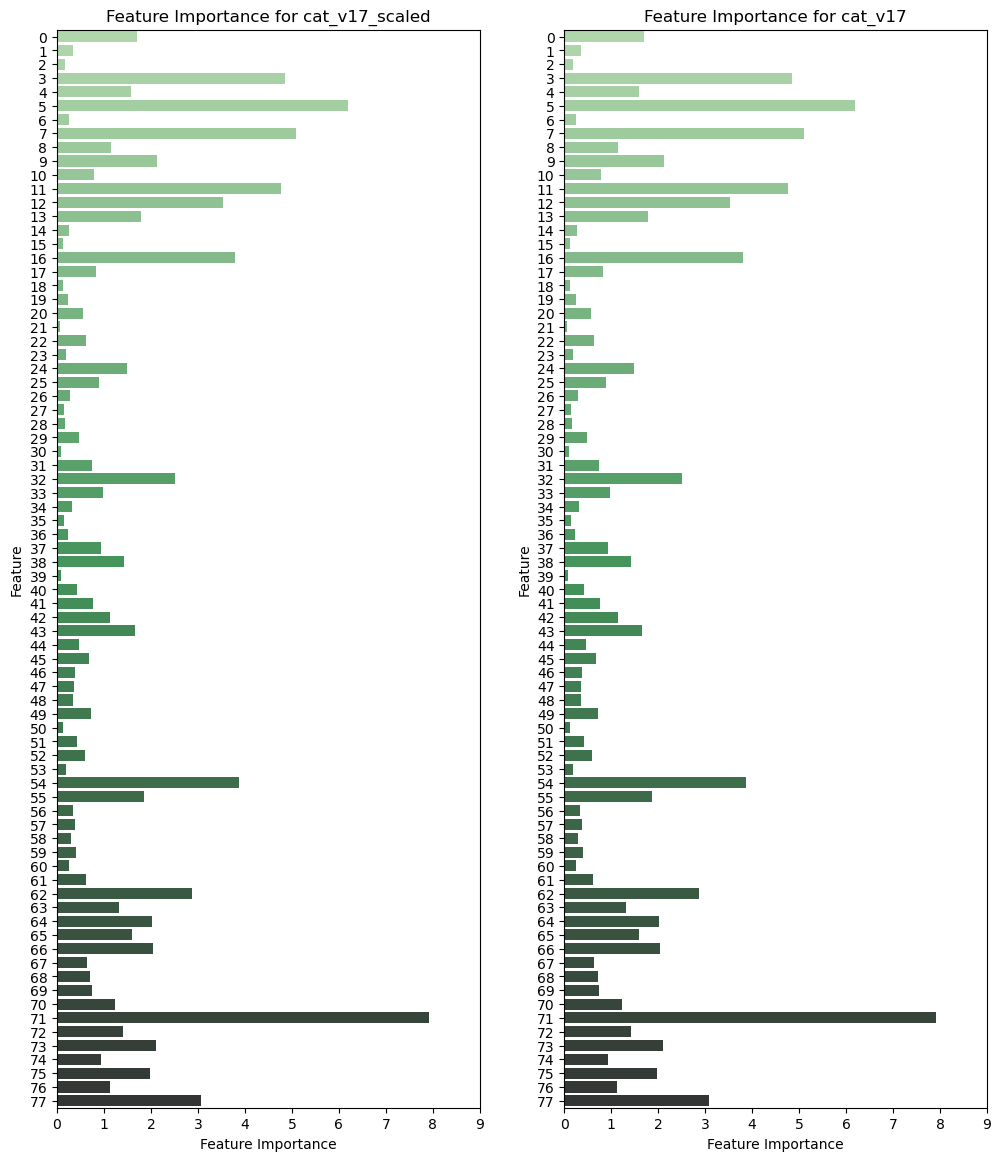

In [8]:
# confirm the impact of scaling -- importance value changes but not feats 
fig, ax = plt.subplots(1, 2, figsize=(12,14))
ax[0] = plt.subplot(1,2,1)
visualize_importance('cat_v17_scaled', feats_v17_ss)
ax[1] = plt.subplot(1,2,2)
visualize_importance('cat_v17', feats_v17)

In [23]:
# how does the TML tree probability change?
print(tml_feats_v15.iloc[13]['Importances'])
print(tml_feats_v17.iloc[13]['Importances'])

1.6636997075333297
1.928476024601695


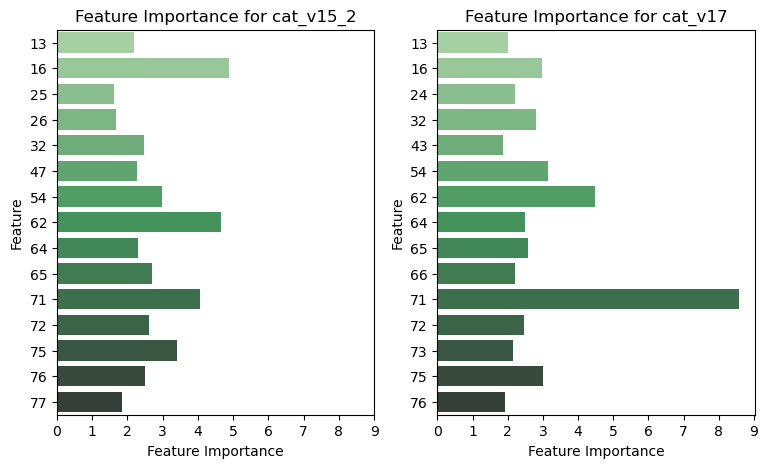

In [22]:
# Let's look at ONLY the TML features
# interesting that TML tree probability was more important before incorporation of natural forests.
fig, ax = plt.subplots(1, 2, figsize=(9,5))
ax[0] = plt.subplot(1,2,1)
visualize_importance('cat_v15_2', tml_feats_v15)
ax[1] = plt.subplot(1,2,2)
visualize_importance('cat_v17', tml_feats_v17)

# Shap Value Analysis

In [10]:
# WARNING: this takes a while to run
# load in v17 training data and model
# (no feature selection or tuning) and calculate shap values
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[], 
                    verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)

with open(f'../models/cat_v17.pkl', 'rb') as file:  
    model = pickle.load(file)
    
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_ss)

53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be removed.


(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 11)
(12, 28, 28, 1

The **summary plot** provides an overview of which features are most important for the model, by plotting the SHAP values of every feature for every sample. It's important not to rely solely on the shap value analysis. Shap importance illustrates how strongly a given feature affects the output of the model, but it doesn't account for the correctness of the prediction.  

This illustrates that high values for feature 71 lower the predicted class. High values for feature 62 increase the predicted class (not sure if -2 is indicative of the negative class?). In this chart, the horizontal spread shows the distribution of shap values for a single feature. The color indicates the relationship between the variables raw value and the shap value.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


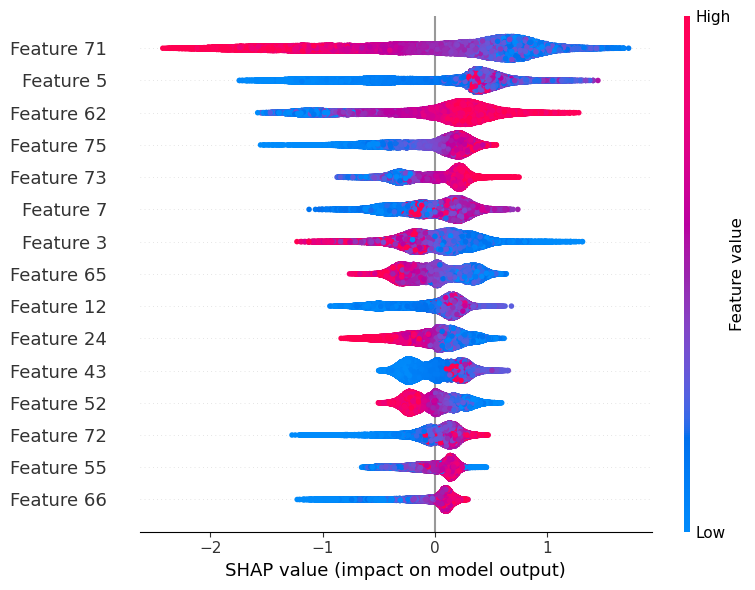

In [14]:
shap.summary_plot(shap_values, 
                  X_train_ss, 
                  max_display=15, 
                  plot_size=[8,6])

The **dependence plot** illustrates the effect of a single feature on the model output. Each dot represents a sample. The horizontal location is the actual value of the feature, and the vertical location shows what having that value did to the prediction. Vertical spread can be confusing, since it indicates that two samples with the same value had a different impact on the prediction. Vertical dispersion (lines) of the data points represents interaction effects. If an interaction feature is not specified shap will automatically select one.  

Notable Results

* **Feature 0**: The vertical lines indicate that feature 0 (DEM)'s shap value is heavily influenced by the value of feature 62. These two features have high interaction.

* **Feature 13**: It makes sense that the impact of feature 13 on the prediction is most significant when the values are around .9 - 1.0, since that would indicate the high tree probability is helping with the plantation classification.  

* **Features 71, 5 and 62**: these features have the greatest influence on the model, with feature 5 and 62 showing a positive linear relationship and 71 showing a negative linear relationship.

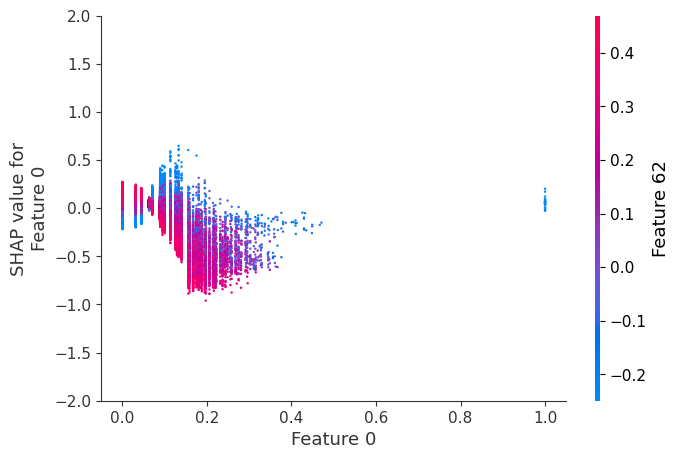

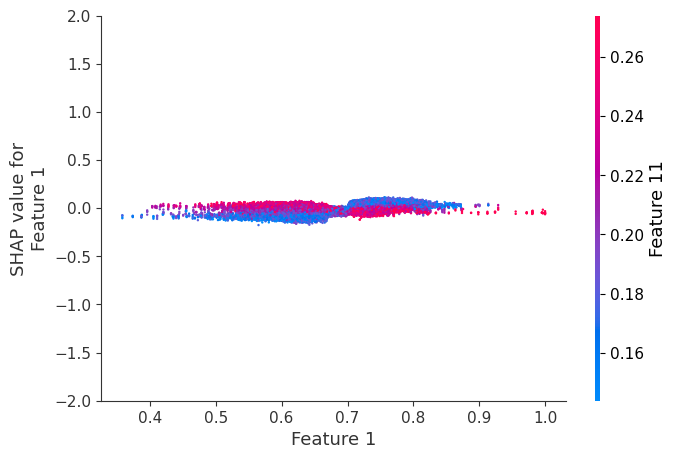

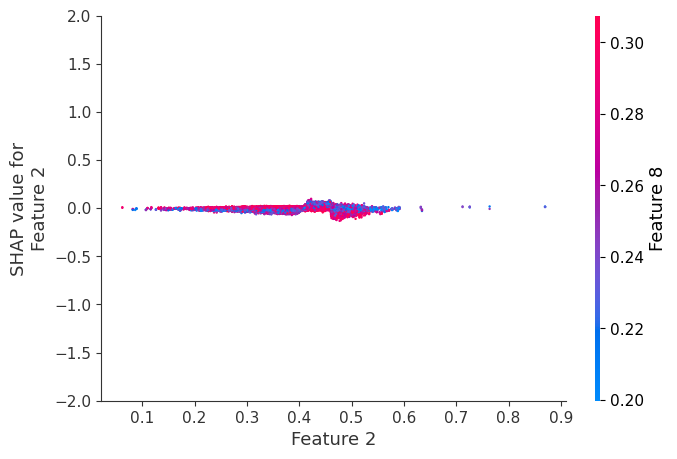

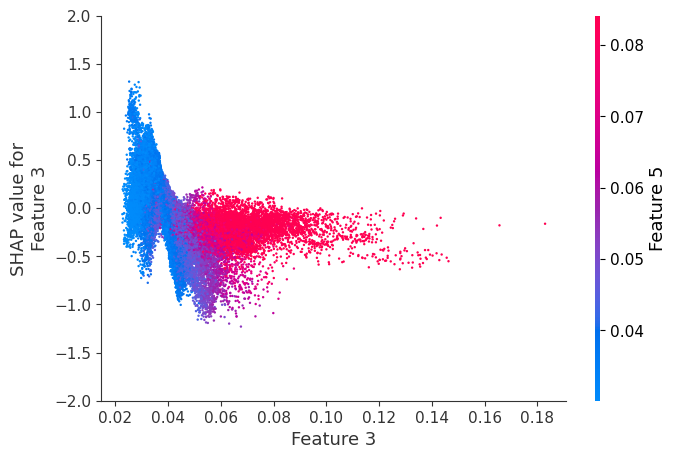

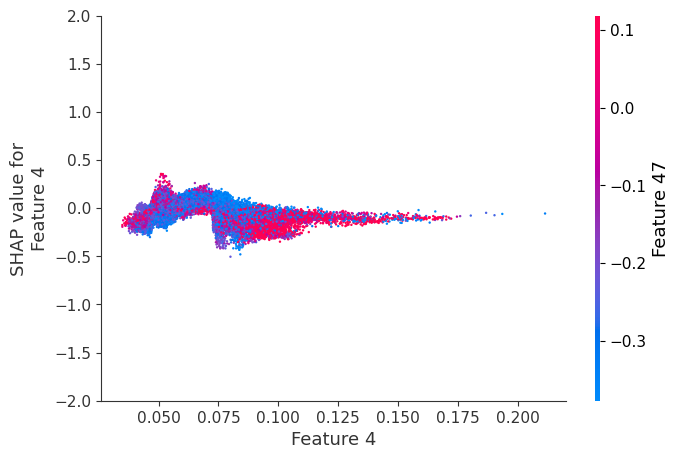

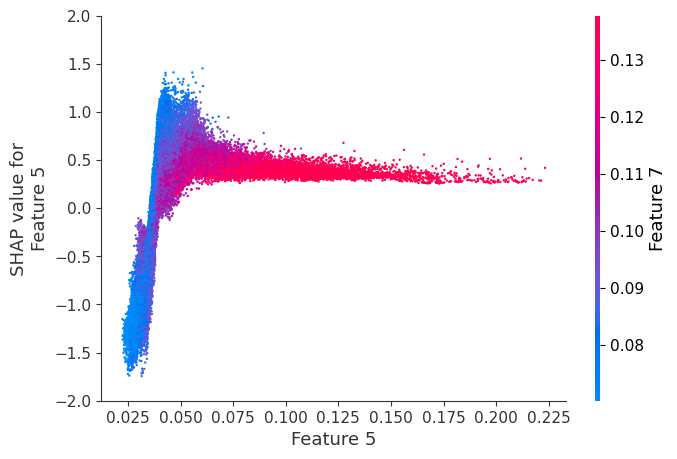

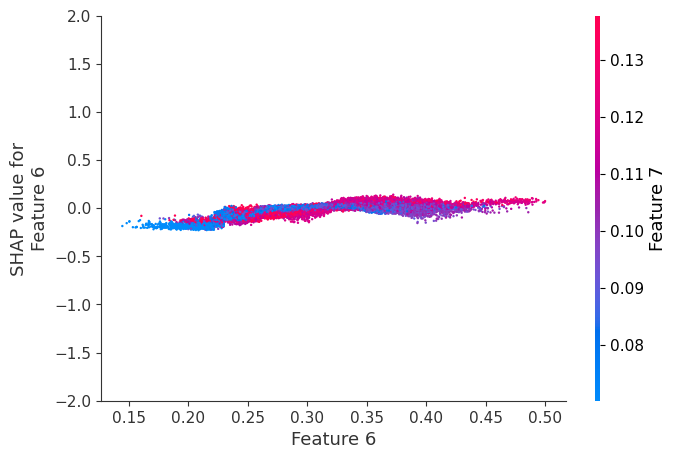

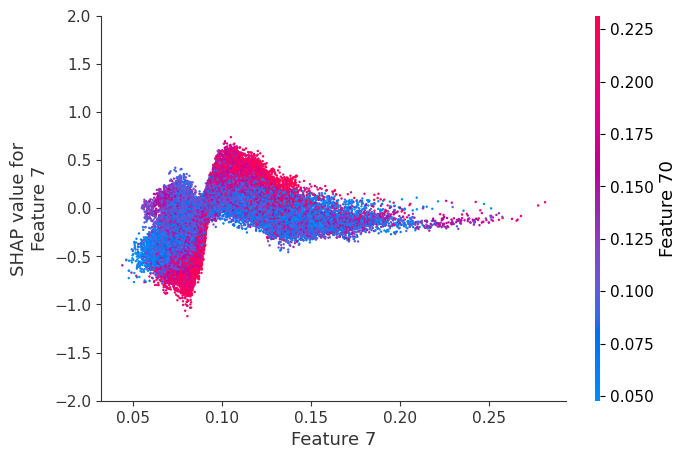

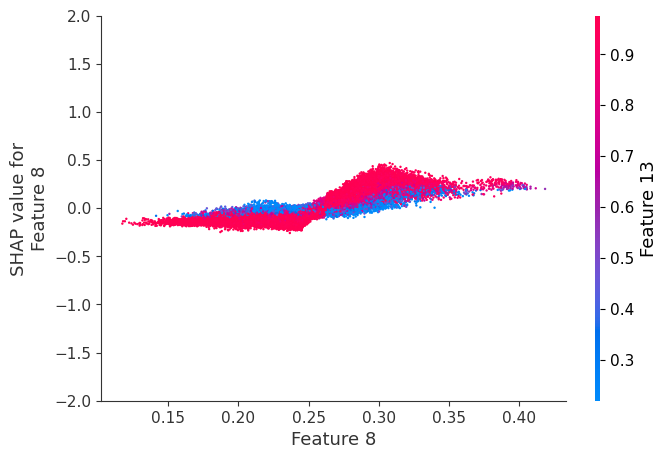

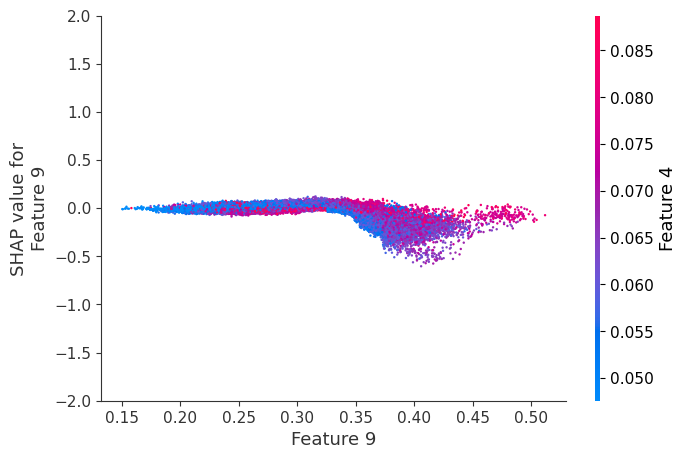

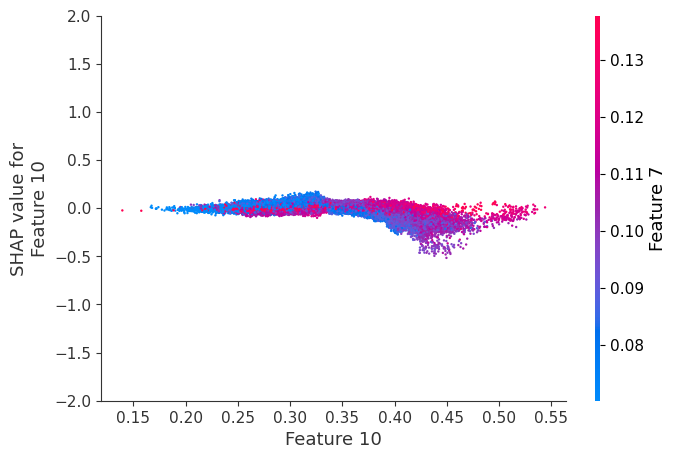

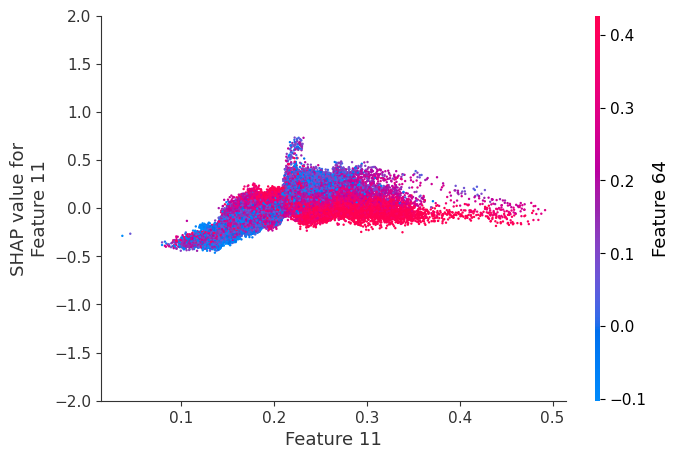

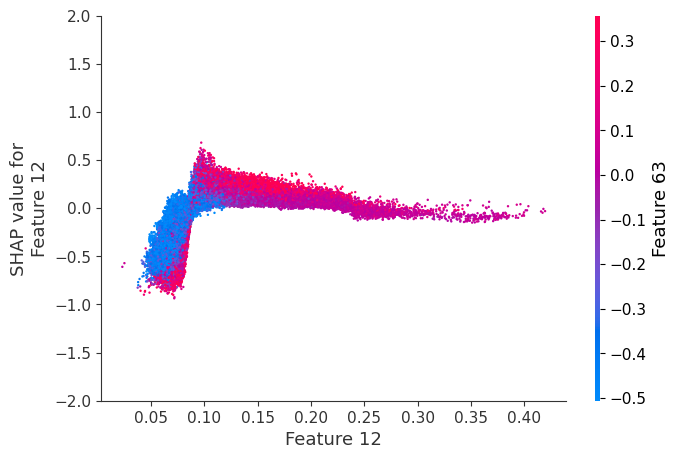

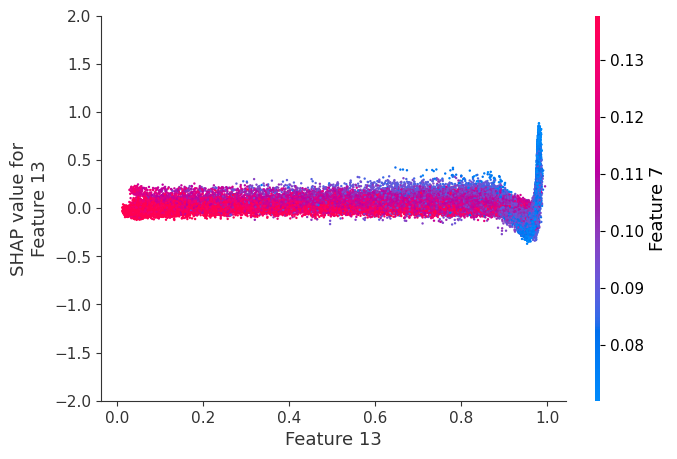

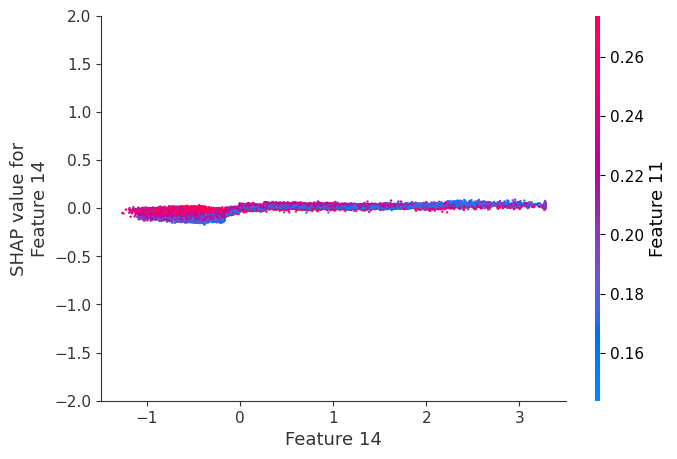

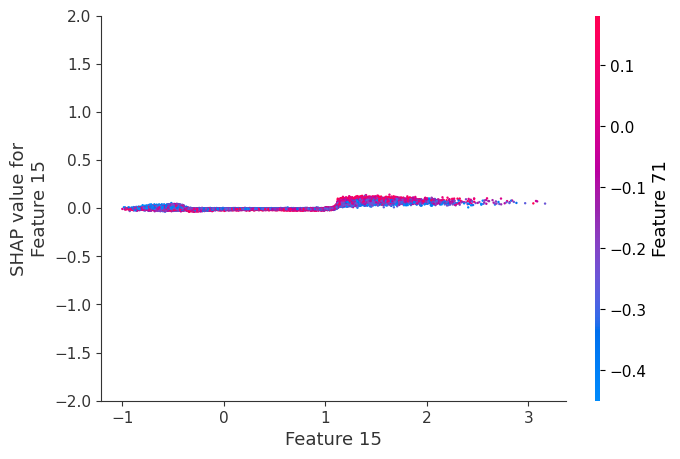

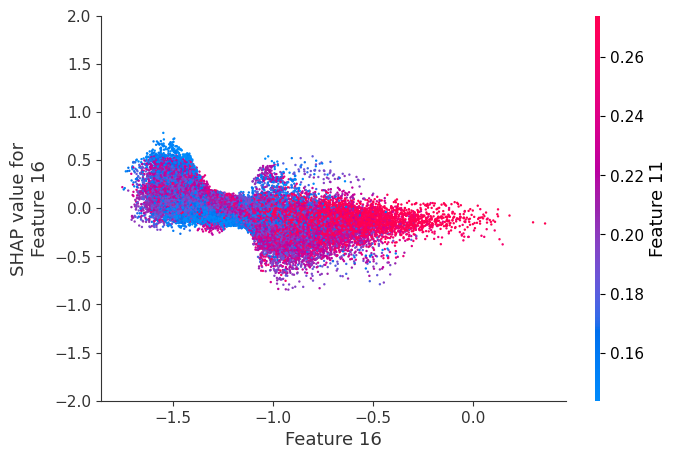

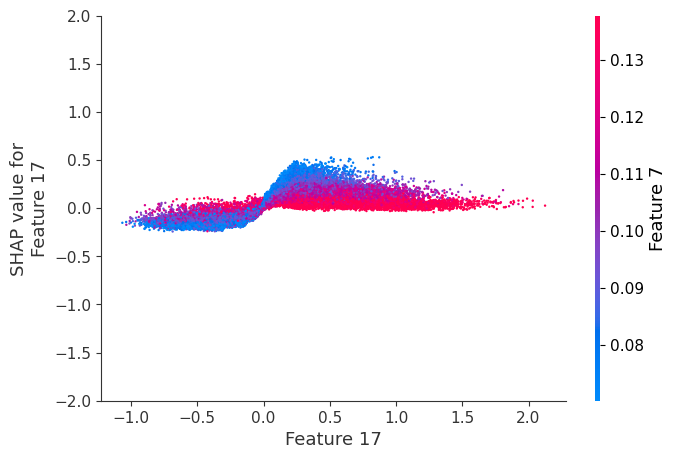

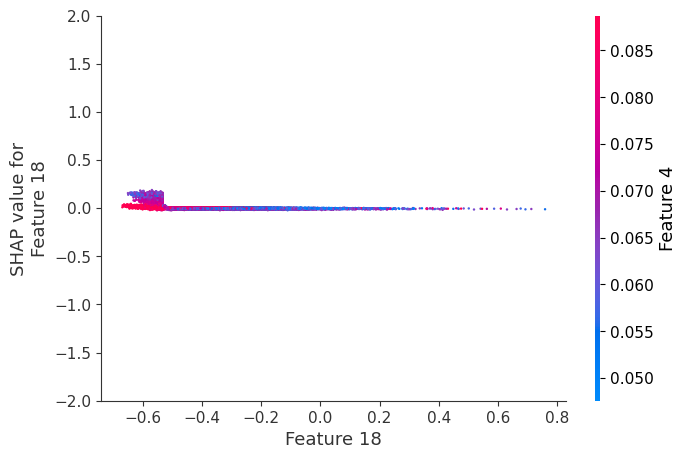

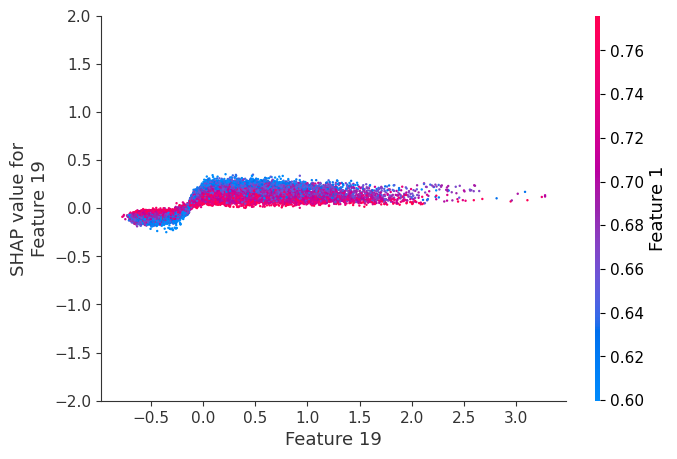

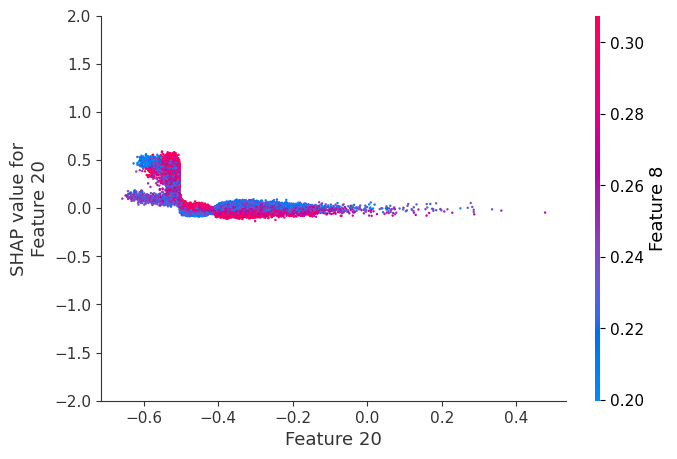

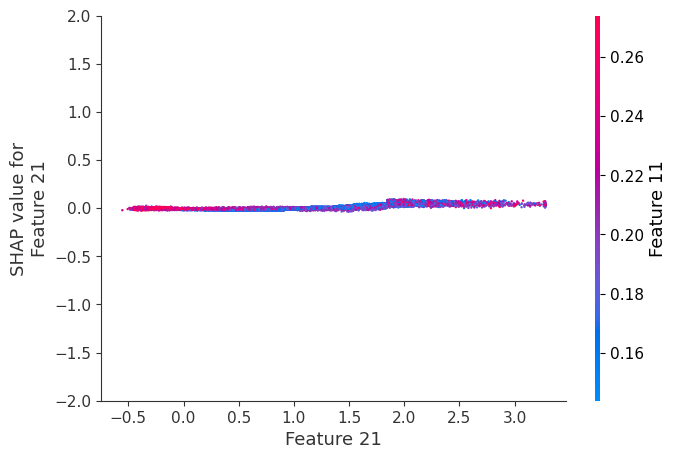

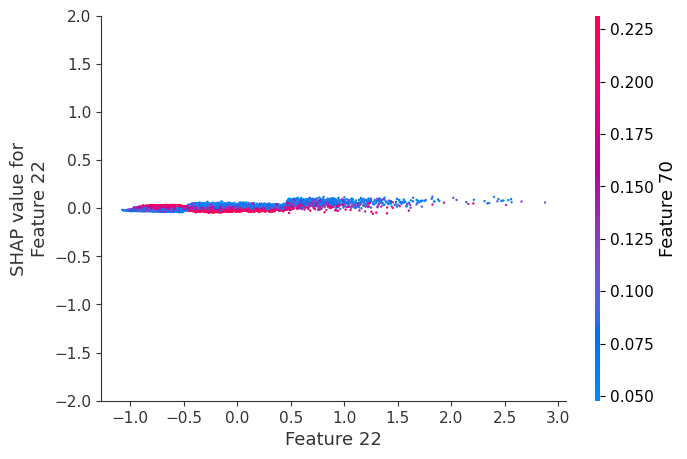

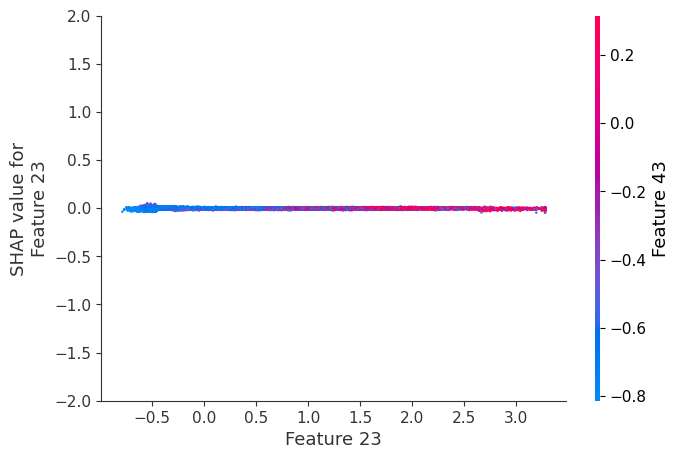

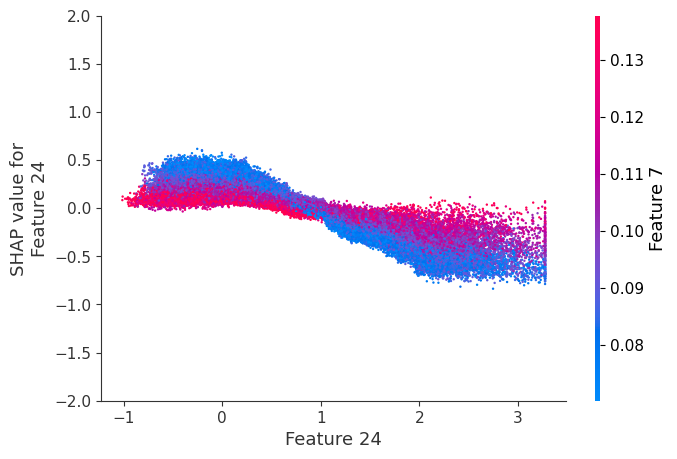

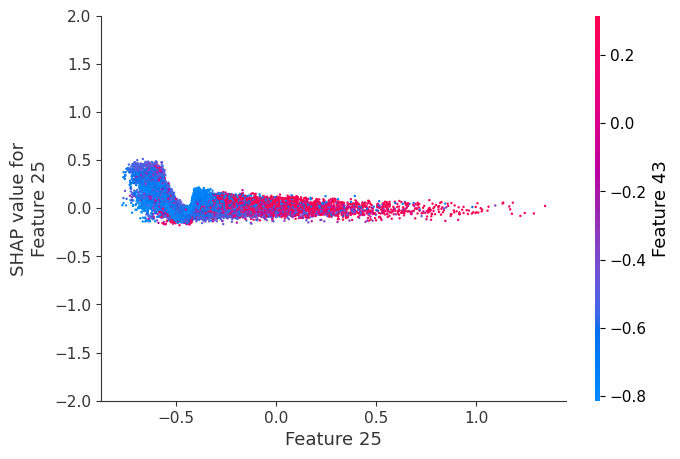

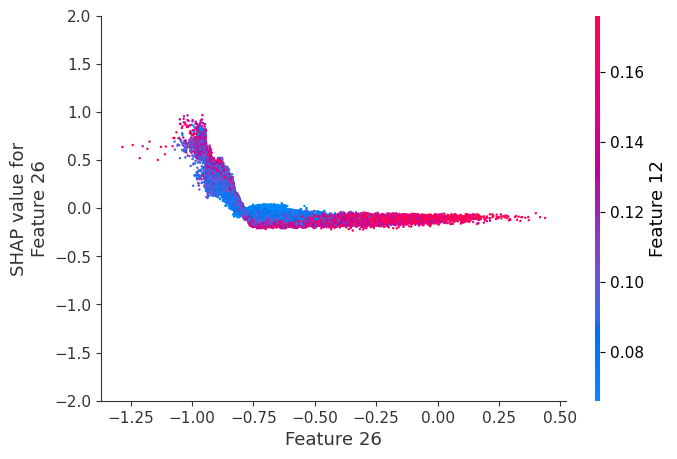

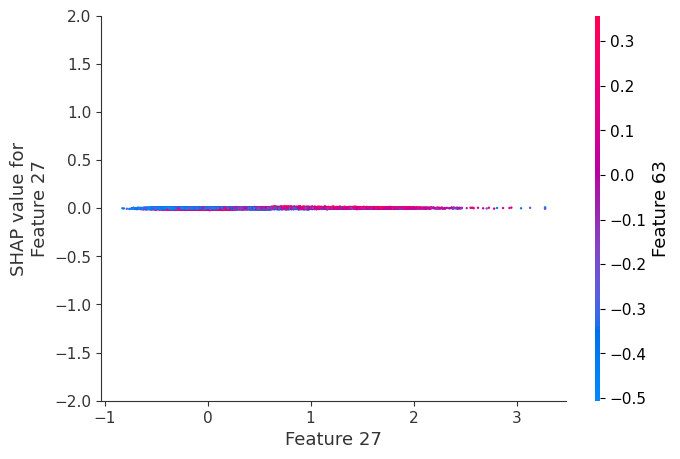

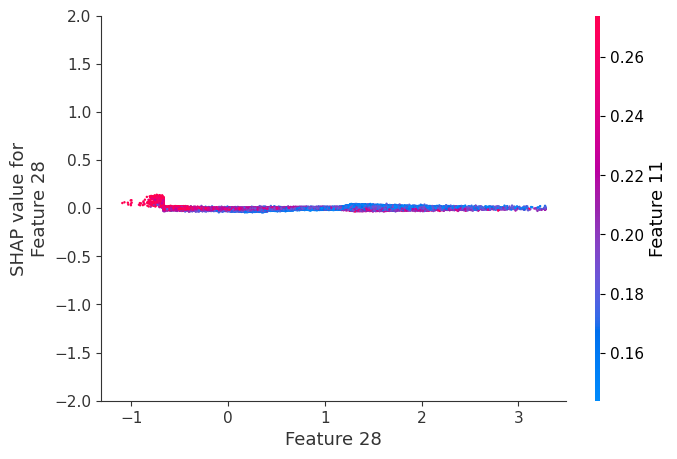

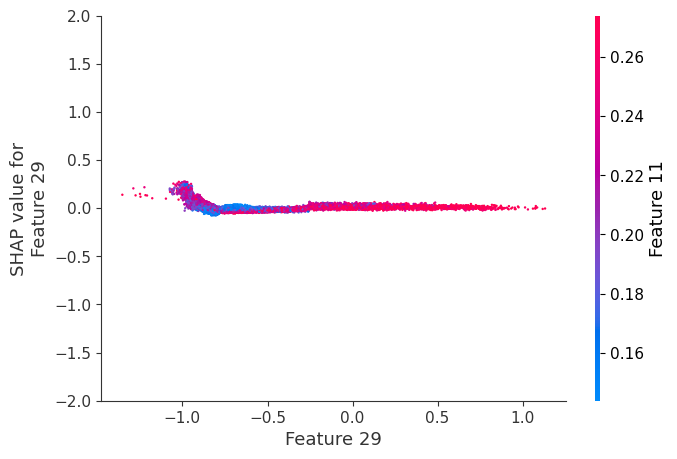

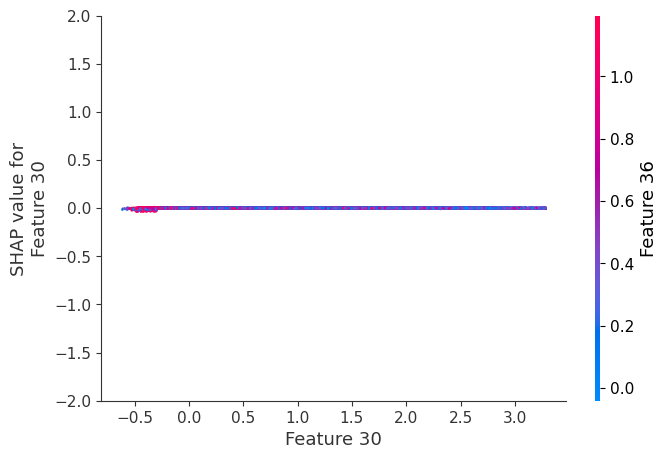

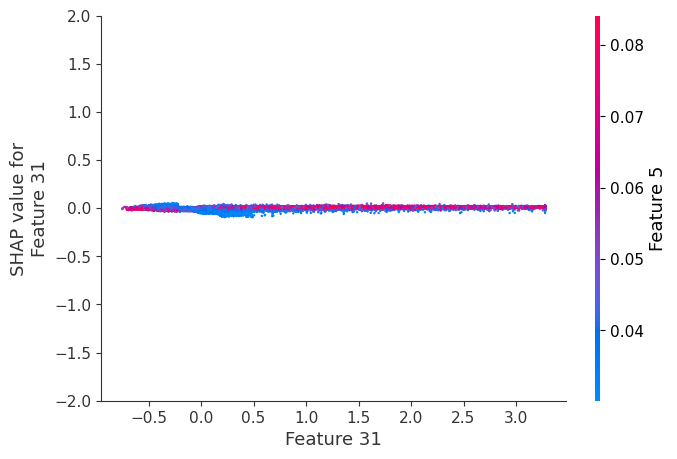

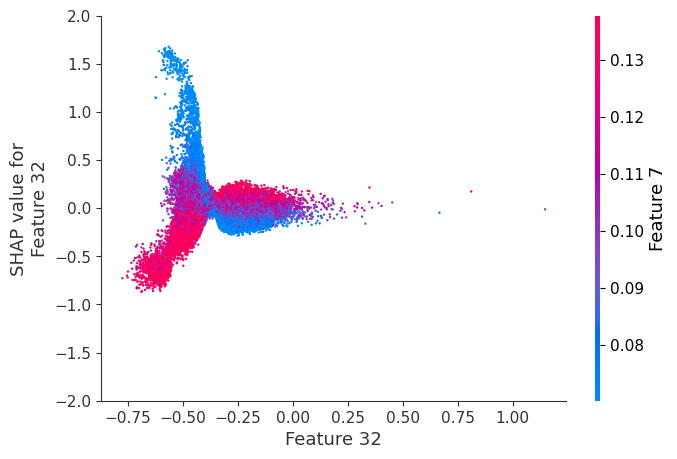

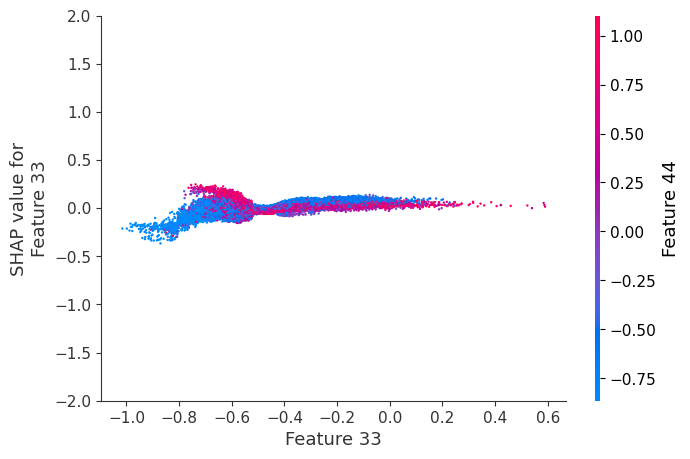

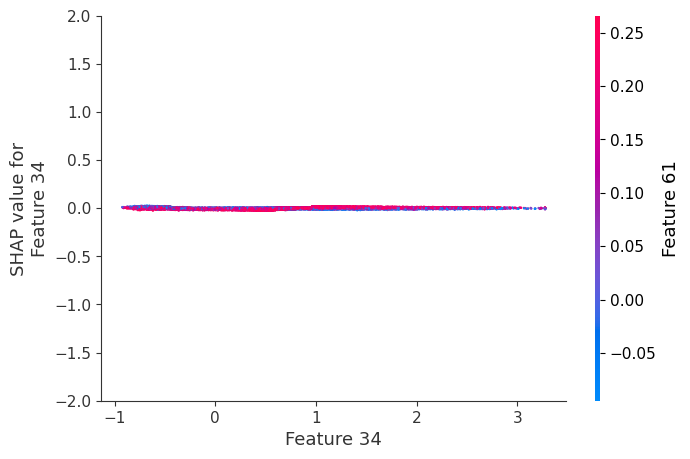

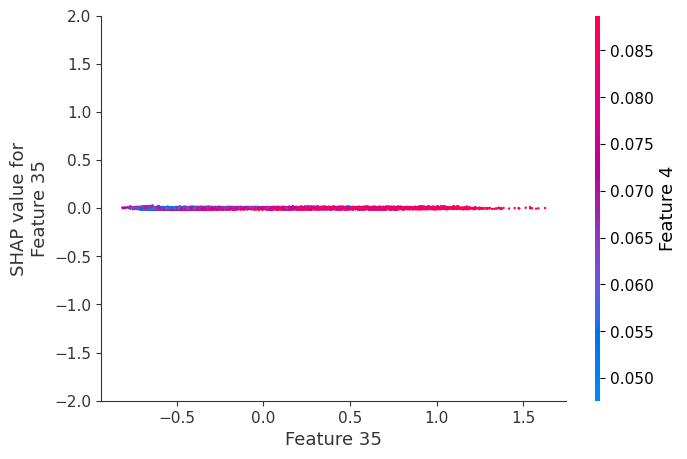

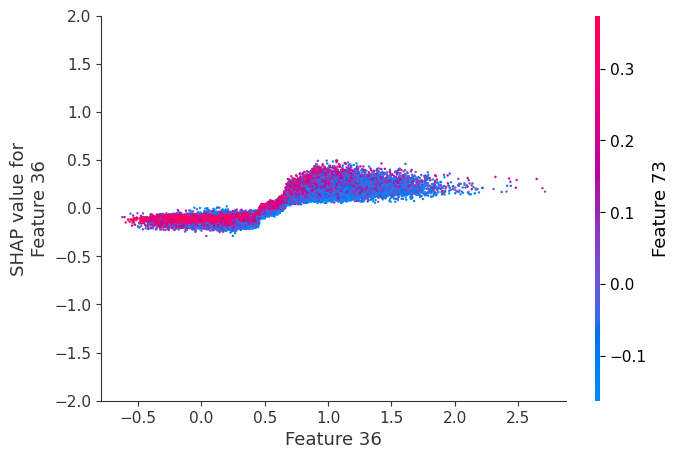

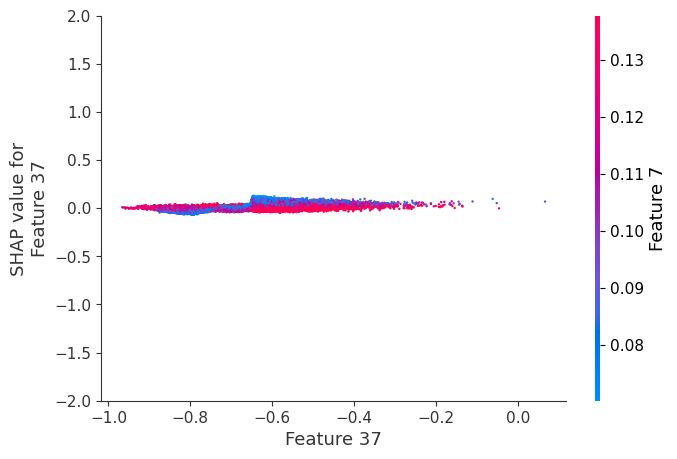

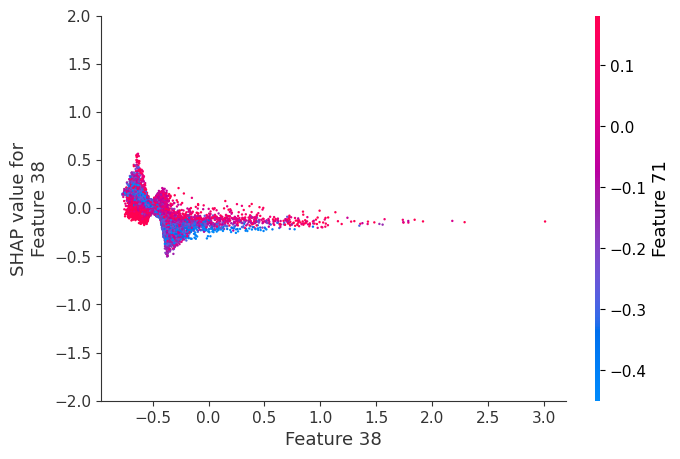

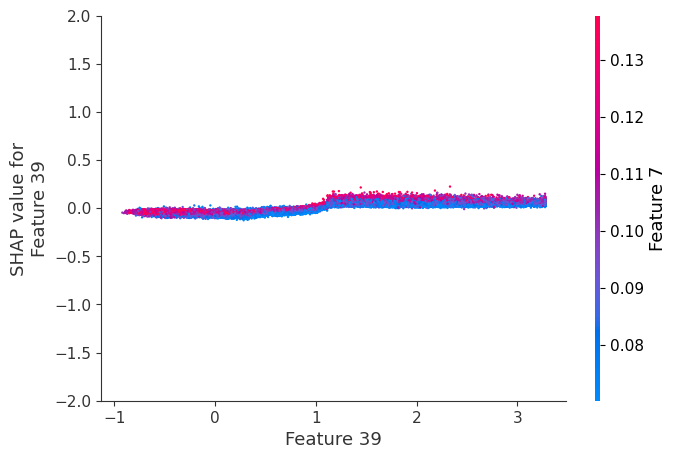

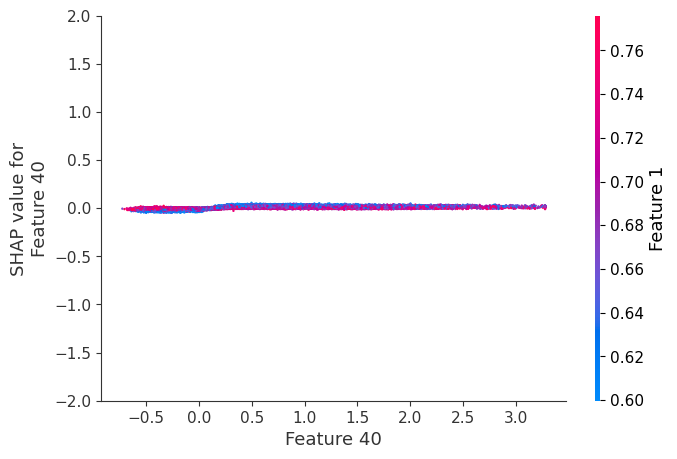

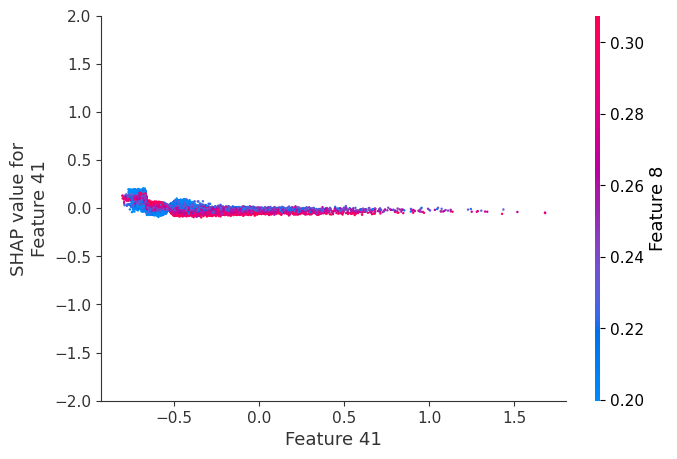

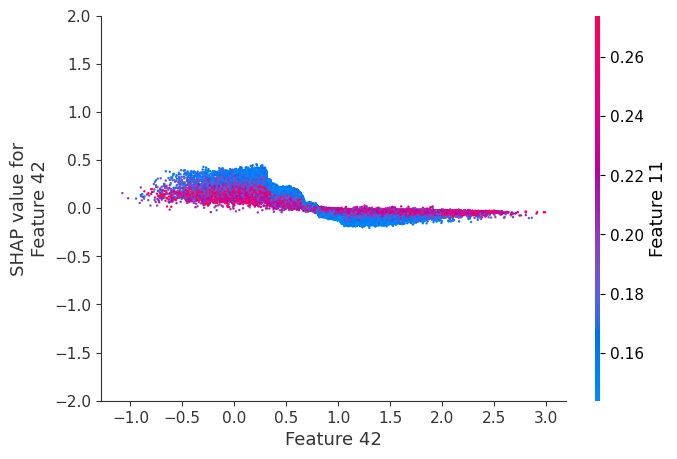

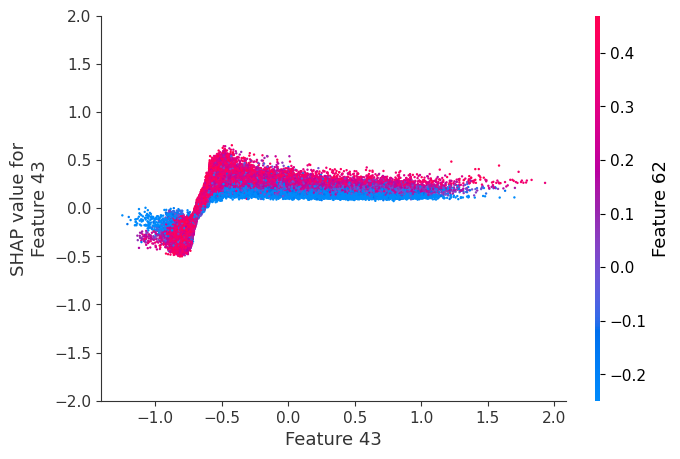

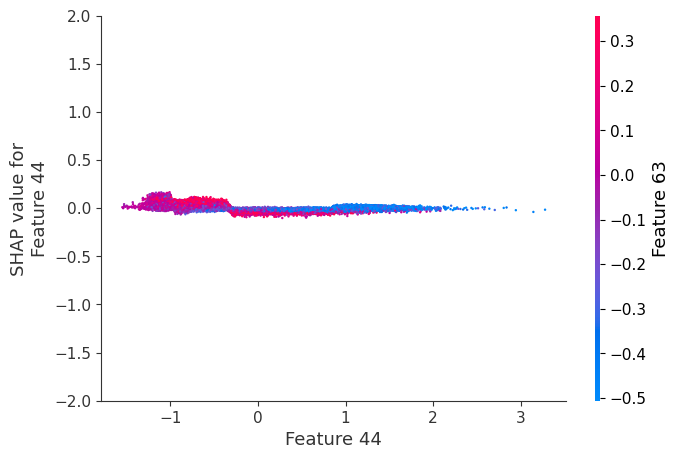

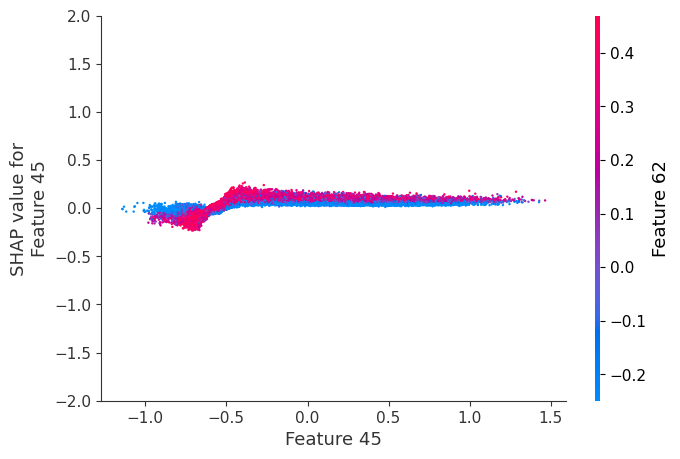

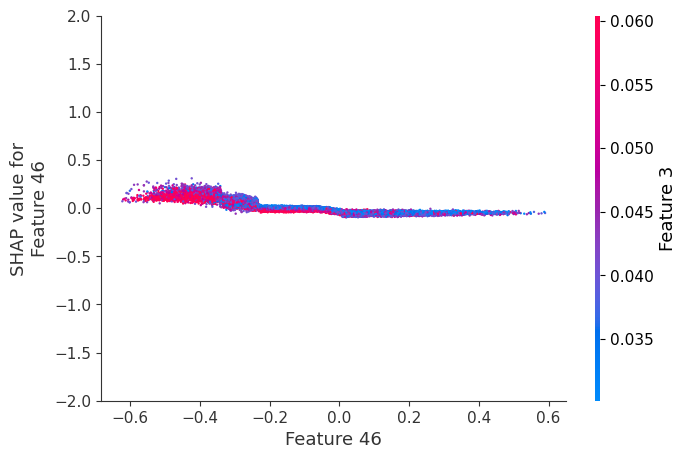

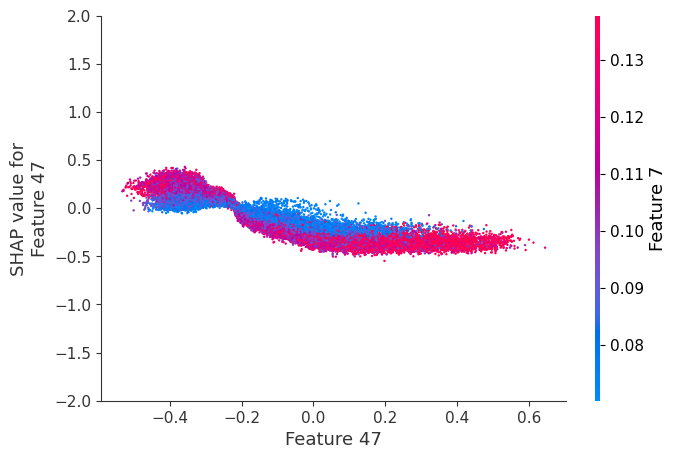

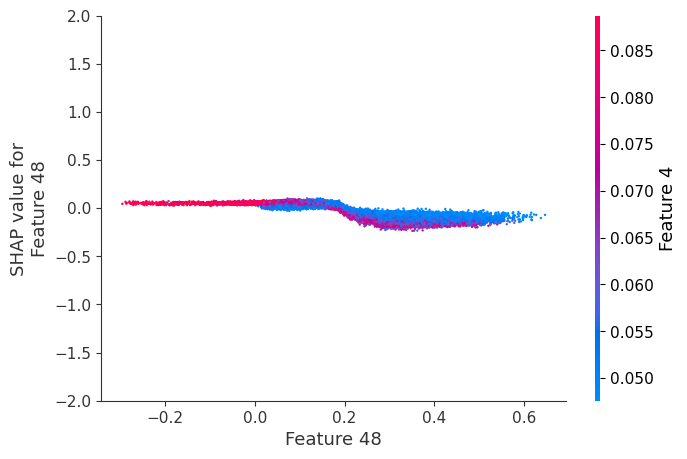

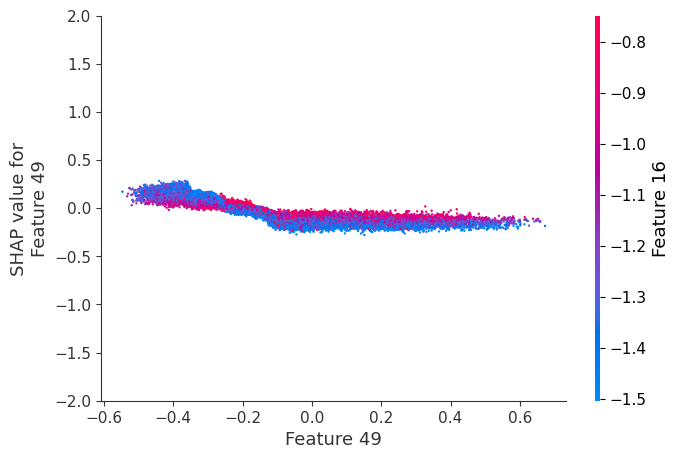

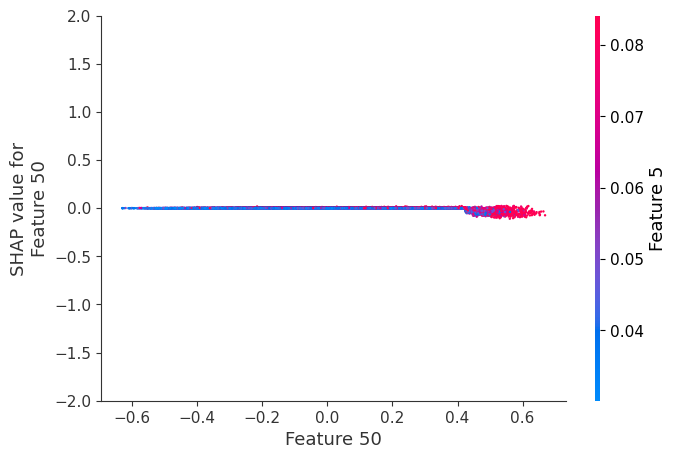

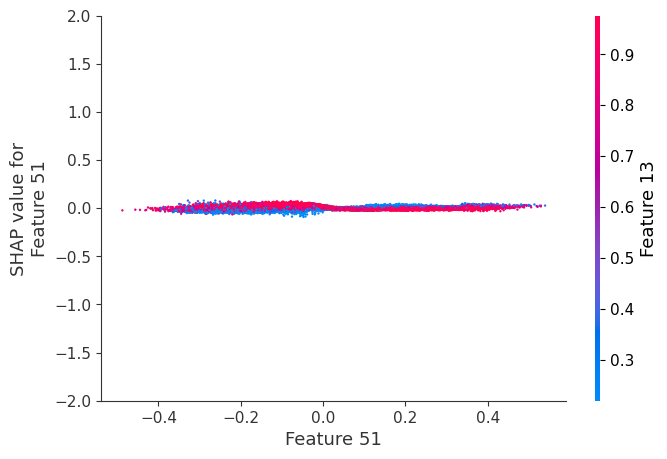

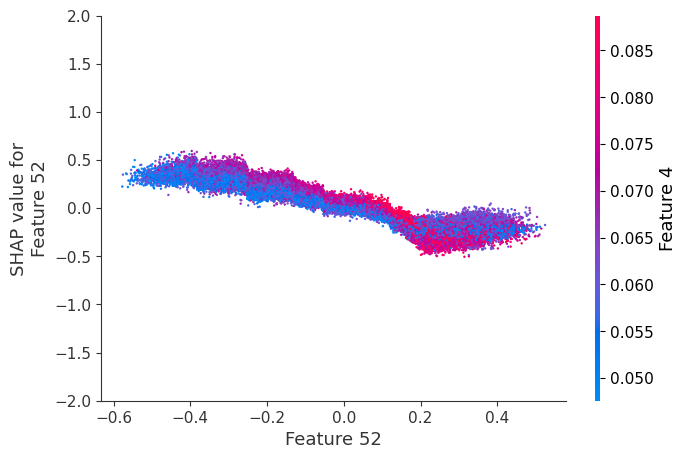

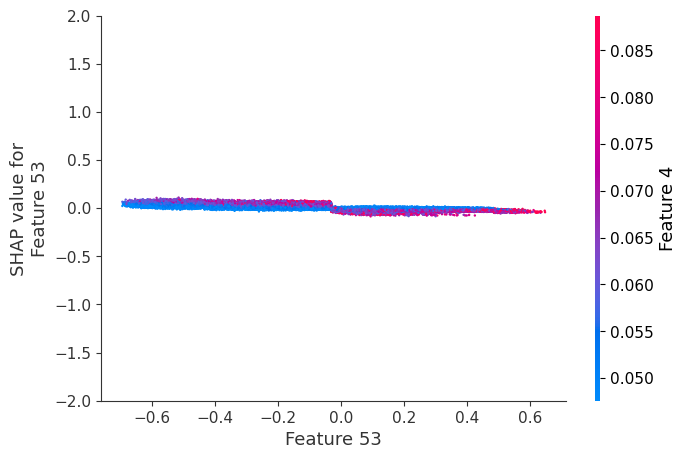

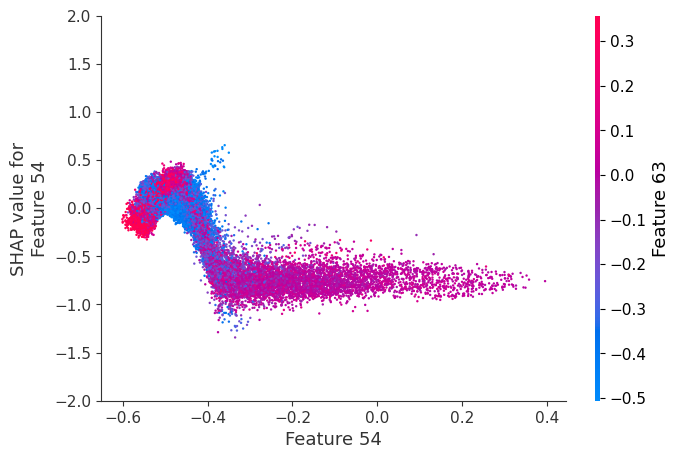

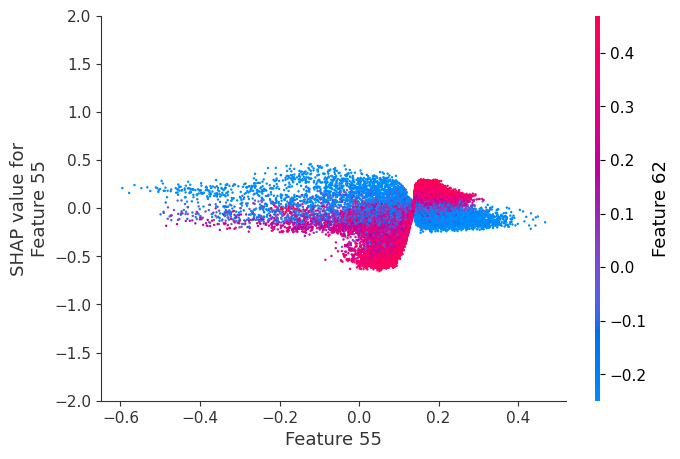

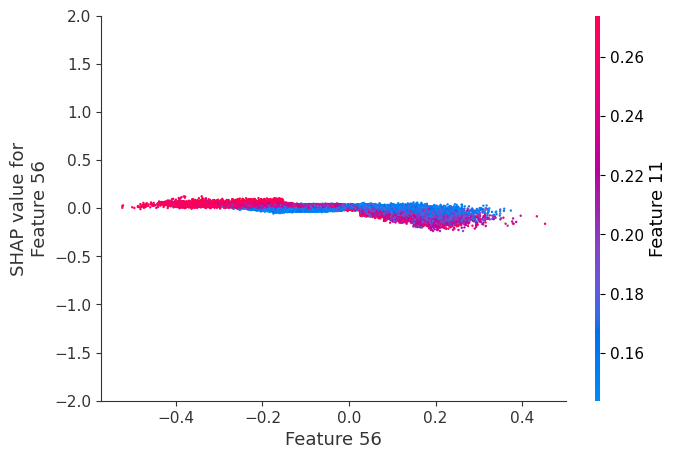

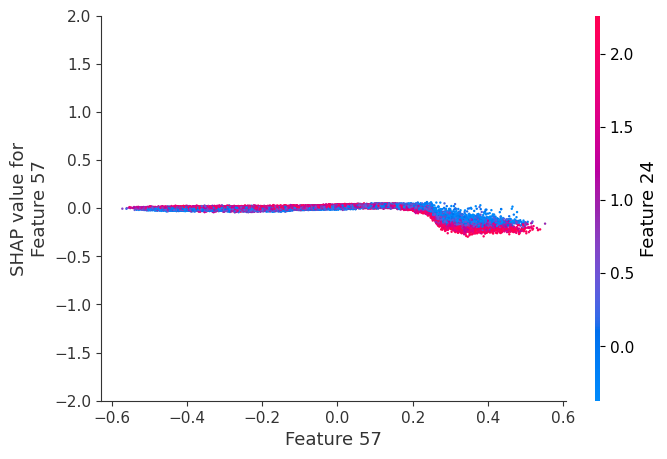

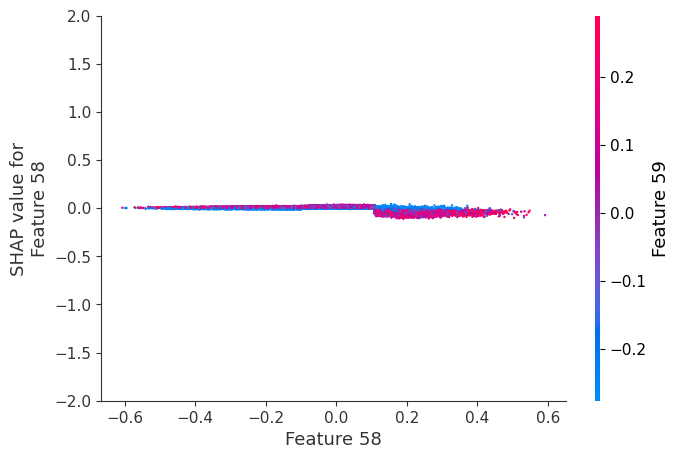

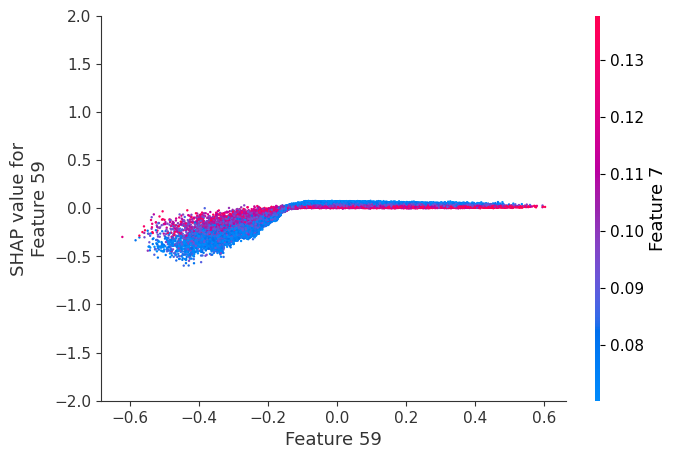

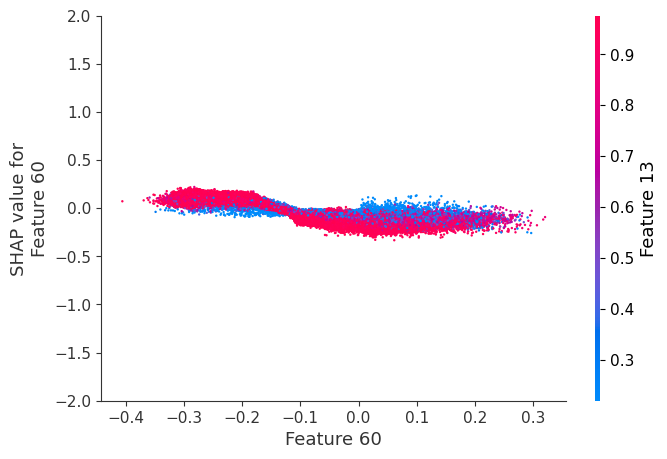

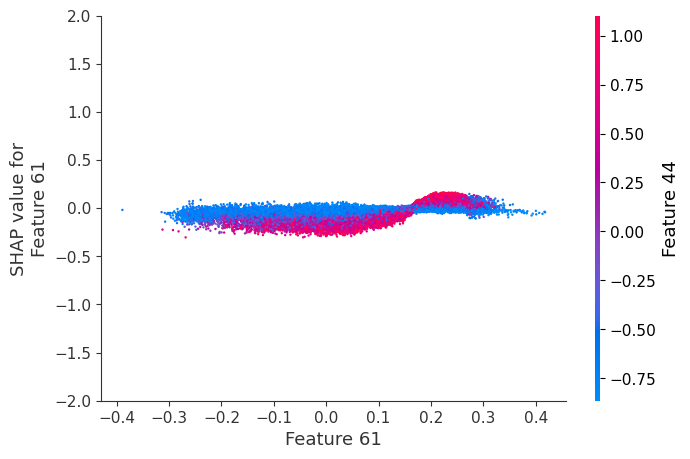

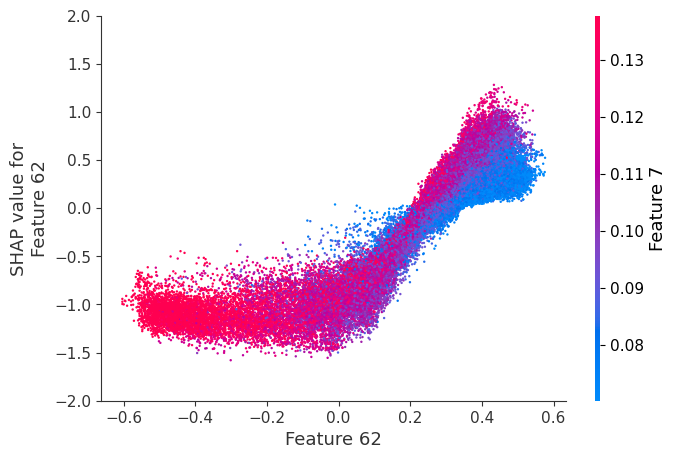

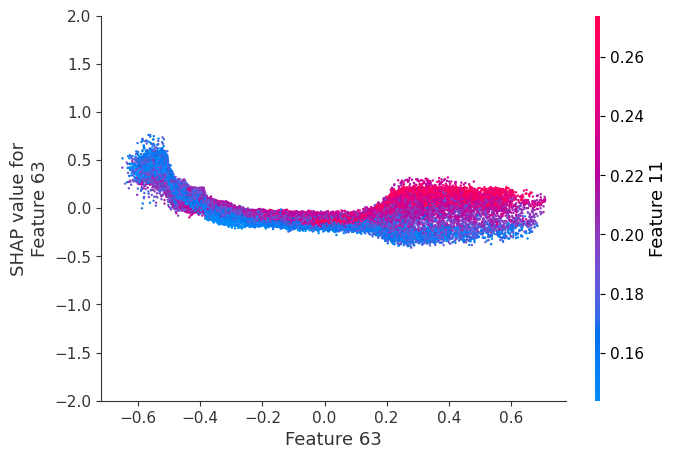

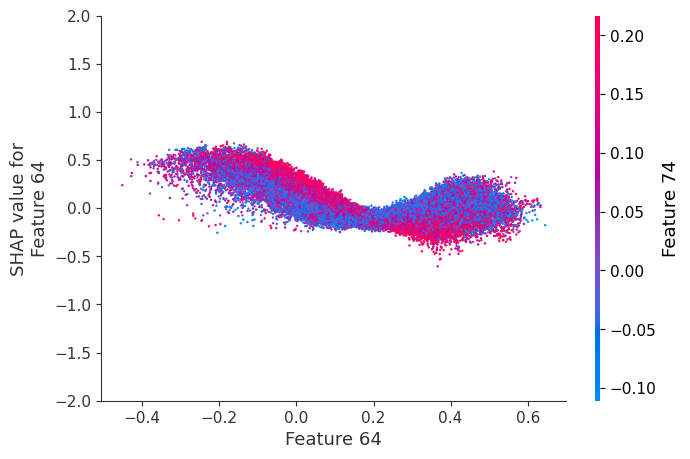

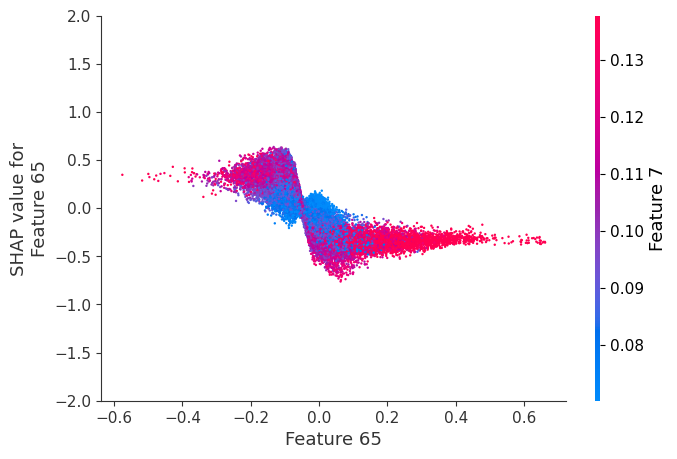

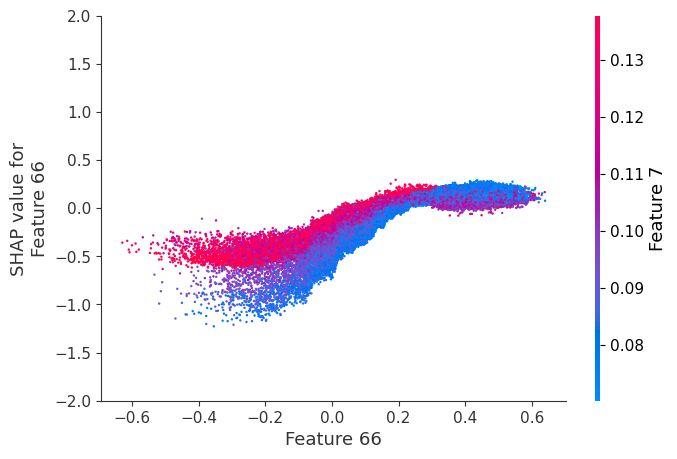

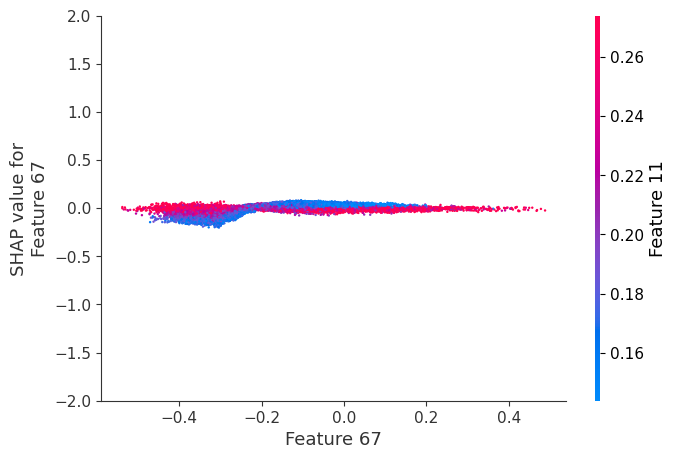

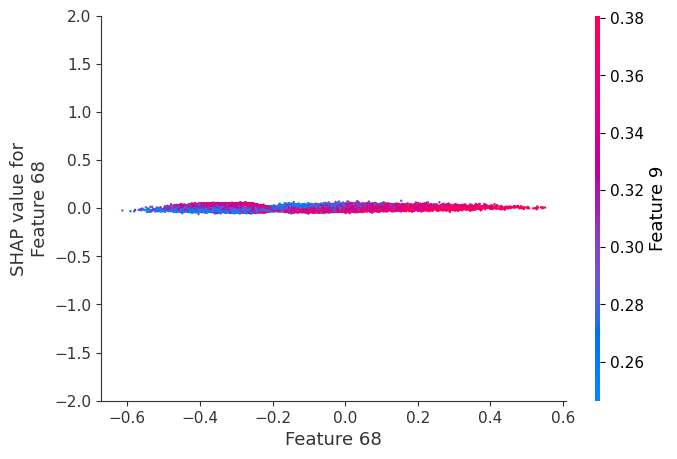

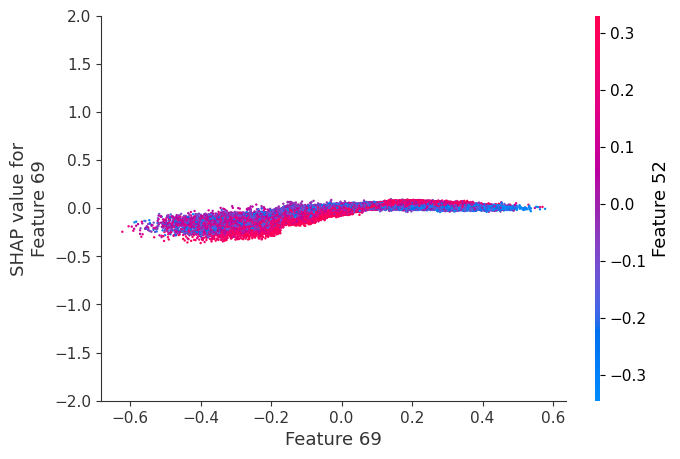

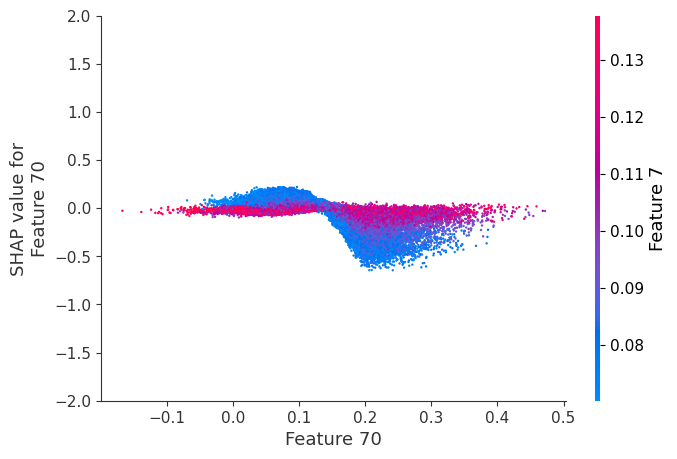

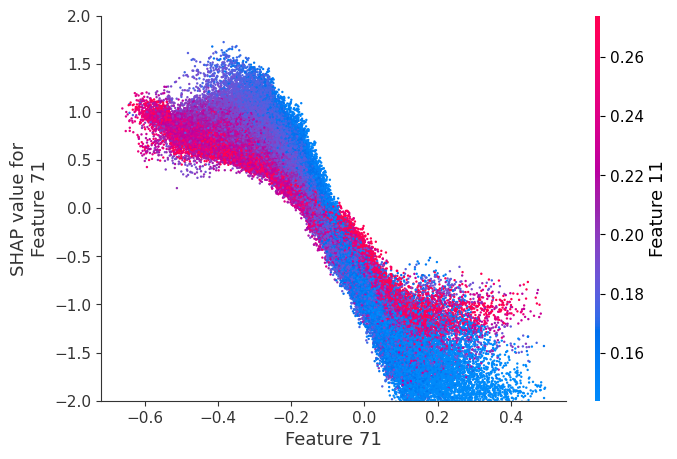

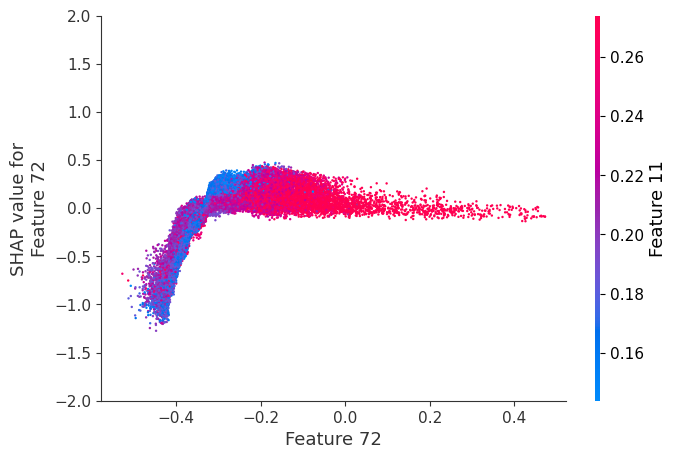

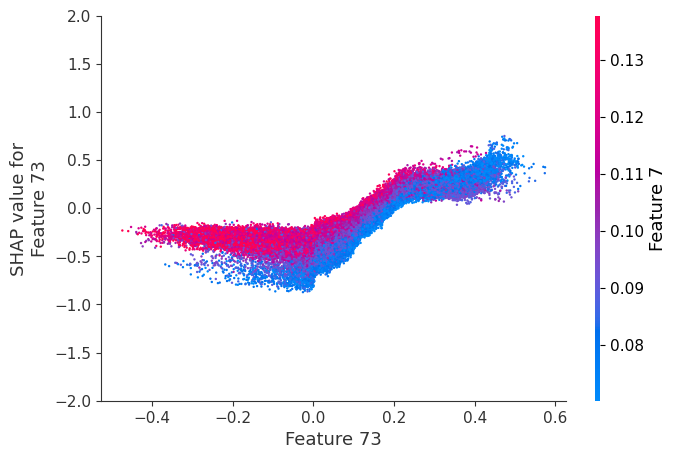

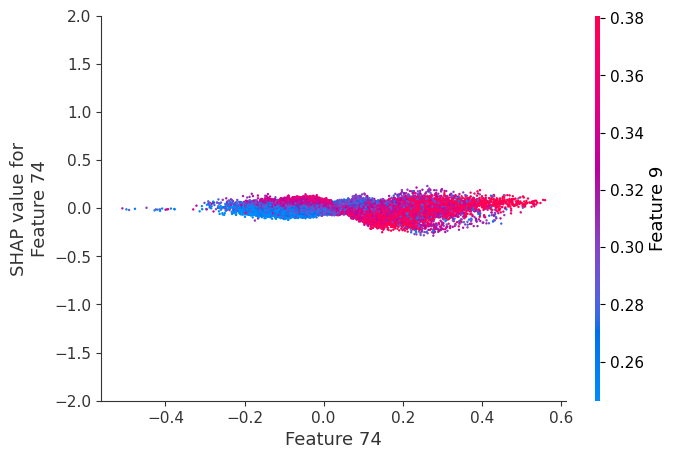

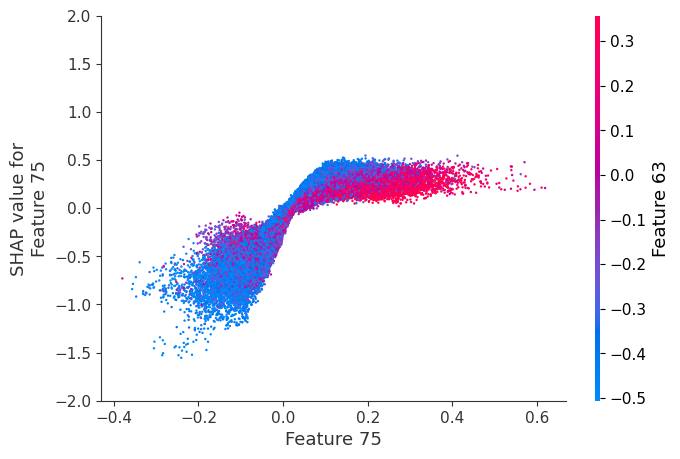

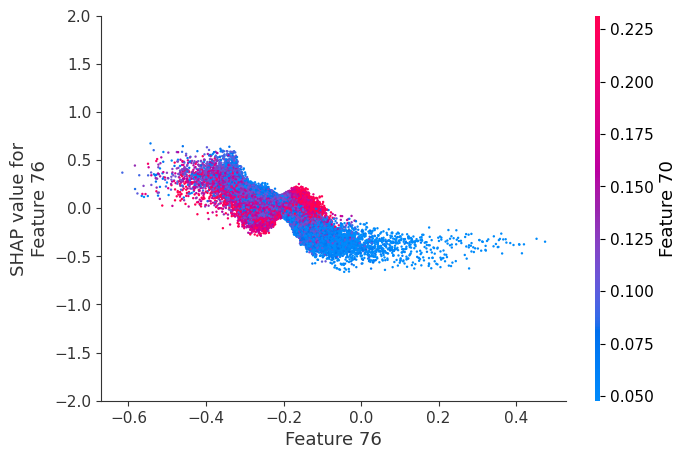

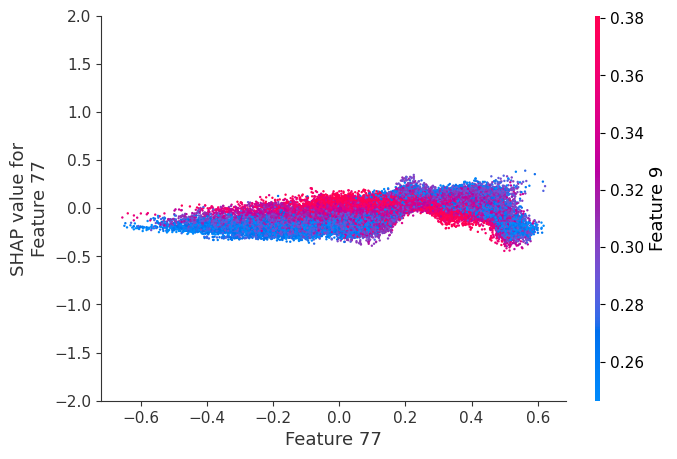

In [15]:
for feature in range(0, 78):
    shap.dependence_plot(feature, shap_values, X_train_ss, dot_size=3, ymin=-2, ymax=2)

## Feature Correlation
We can use `shap.approximate_interactions` to understand which features may interact with one another. This orders other features by how much interaction they seem to have with the feature at the given index (in this case, feature `13` which is the TML tree probability). 

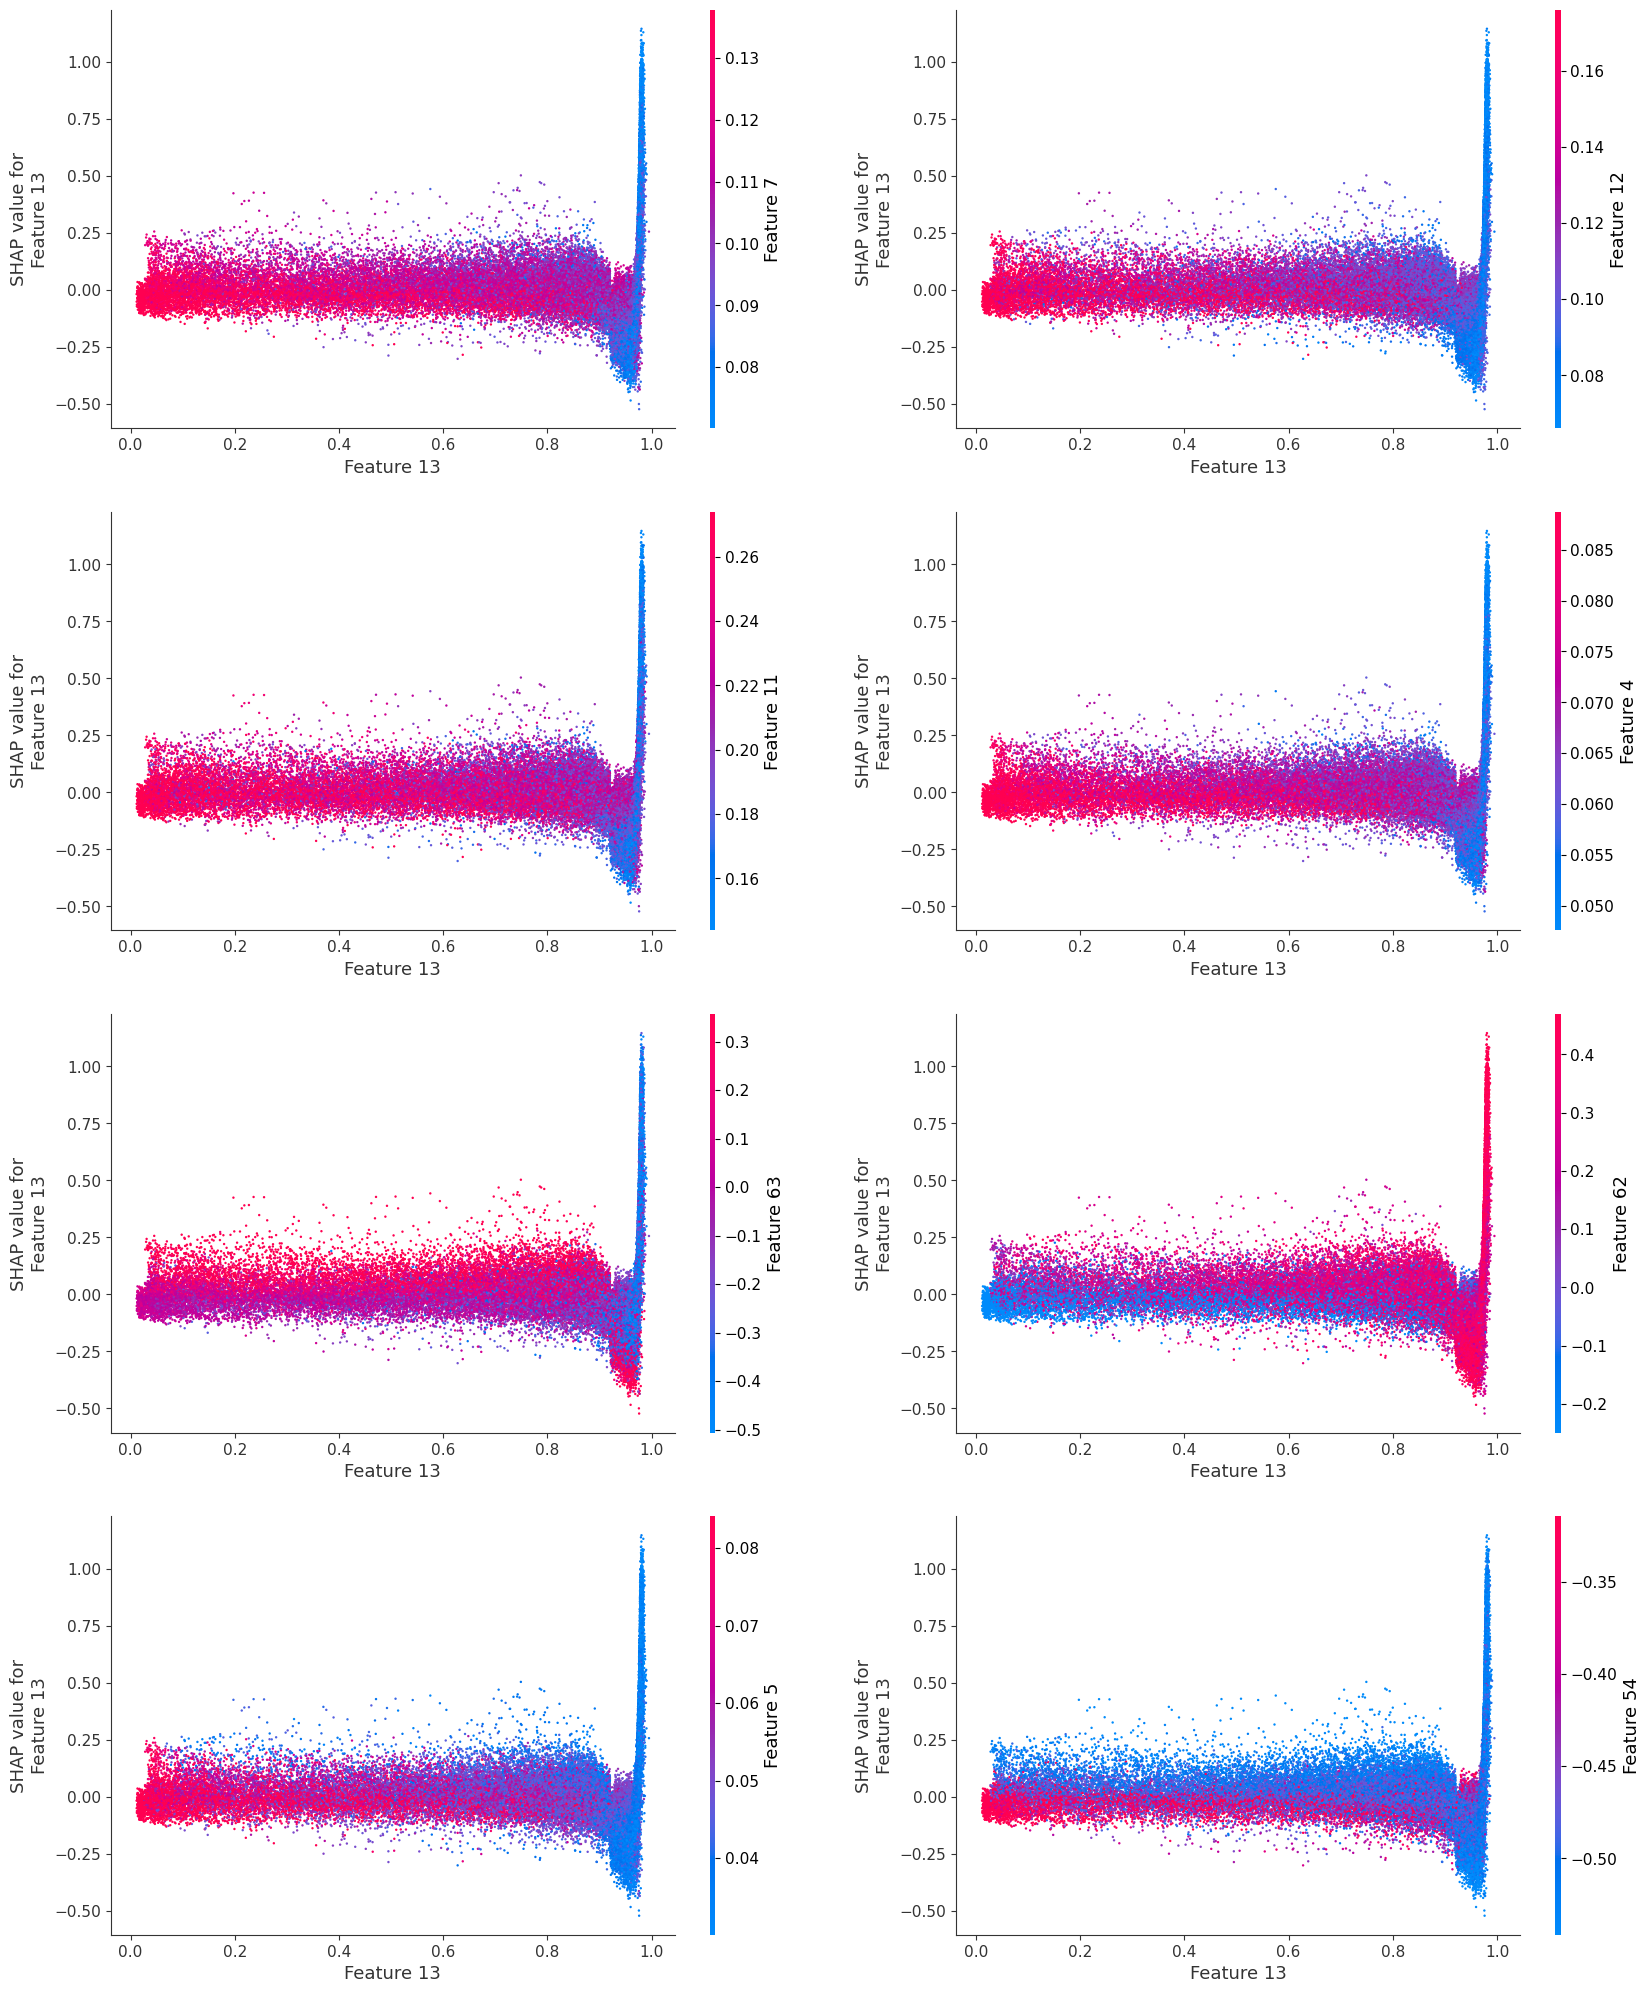

In [43]:

fig, ax = plt.subplots(4,2, figsize=(20,25))

feat = 13
inds = shap.approximate_interactions(feat, shap_values, X_train_ss)

shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[0], ax=ax[0,0], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[1], ax=ax[0,1], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[2], ax=ax[1,0], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[3], ax=ax[1,1], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[4], ax=ax[2,0], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[5], ax=ax[2,1], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[6], ax=ax[3,0], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[7], ax=ax[3,1], show=False)

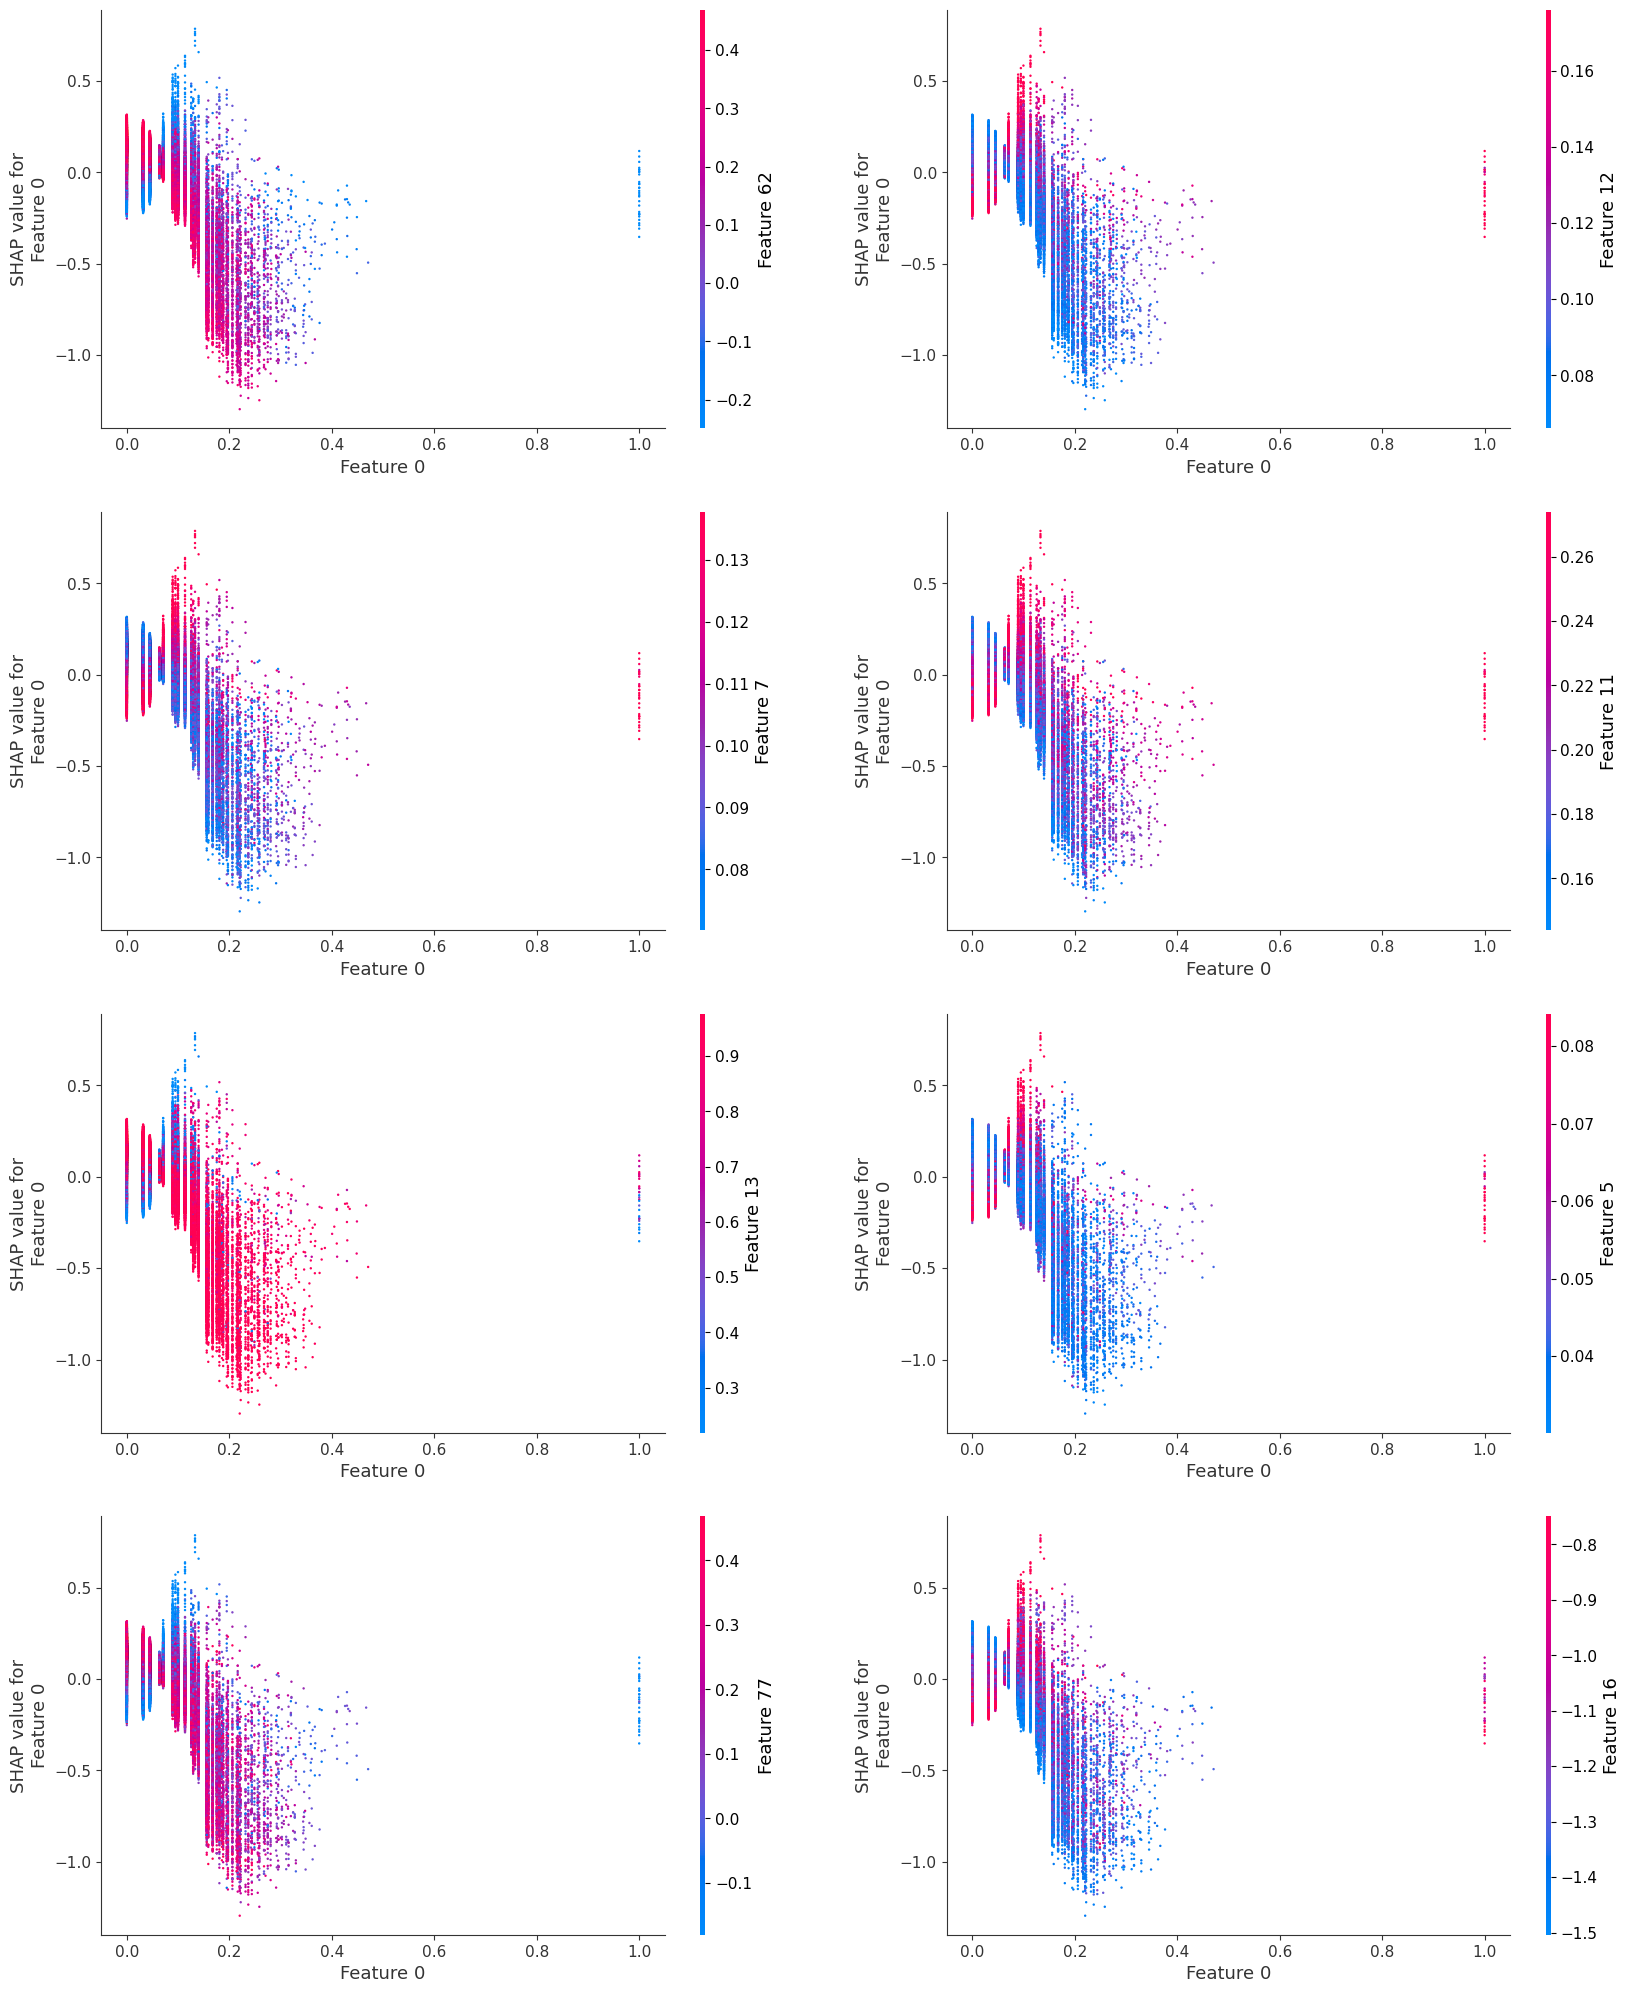

In [44]:
# do the same for feature 0, which appeared to have interactions in the original dependence plot

fig, ax = plt.subplots(4,2, figsize=(20,25))

feat = 0
inds = shap.approximate_interactions(feat, shap_values, X_train_ss)

shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[0], ax=ax[0,0], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[1], ax=ax[0,1], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[2], ax=ax[1,0], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[3], ax=ax[1,1], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[4], ax=ax[2,0], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[5], ax=ax[2,1], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[6], ax=ax[3,0], show=False)
shap.dependence_plot(feat, shap_values, X_train_ss, dot_size=3, interaction_index=inds[7], ax=ax[3,1], show=False)

# Hyperparameter Tuning
Hyperparameter tuning was informed by [Catboost Documentation](https://catboost.ai/en/docs/concepts/parameter-tuning#iterations) and using CatBoost's built in method for randomized searches. Generally speaking, Catboost's default parameters will provide a strong result, but the tuning adjustments can bring minor improvements.

In [11]:
df = pd.read_csv('../models/mvp_scores.csv')
starter_model = df.tail(4)
starter_model

model   class  tml_feats      cv  train_score  test_score  \
98          cat_v15   multi        NaN  0.8269       0.9807      0.7970   
99          cat_v17  binary       65.0  0.8901       0.9815      0.8918   
100  cat_v17_scaled  binary       65.0  0.8902       0.9820      0.8912   
101      cat_v17_fs  binary       40.0  0.8879       0.9806      0.8916   

     roc_auc  precision  recall      f1        date  
98       NaN     0.7937  0.7970  0.7945     3/21/23  
99    0.9470     0.9254  0.9185  0.9220  2023-03-21  
100   0.9472     0.9263  0.9166  0.9214  2023-03-21  
101   0.9476     0.9273  0.9160  0.9216  2023-03-21

In [12]:

def random_search_cat(X_train_ss, y_train, train_v):
    '''
    Performs a randomized search of hyperparameters using Catboost's built in
    random search method and plots the results, then
    and saves results to a csv file
    '''
    # Get the count of features used
    tml_feat_count = X_train_ss.shape[1] - 13
    
    iterations = [int(x) for x in np.linspace(400, 1100, 10)]            # equiv to n_estimators
    depth = [int(x) for x in np.linspace(4, 10, 4)]                      # equiv to max_depth (must be <= 16)
    l2_leaf_reg = [int(x) for x in np.linspace(2, 30, 4)]
    learning_rate = [.01, .02, .03]                                      # decrease learning rate if overfitting 

    param_dist = {'iterations': iterations,
                  'depth': depth,
                  'l2_leaf_reg': l2_leaf_reg,
                  'learning_rate': learning_rate}

    # instantiate the classifier and perform Catboost built in method for random search
    cat = CatBoostClassifier(random_seed=22, verbose=False)
    randomized_search_result = cat.randomized_search(param_dist,
                                                     X=X_train_ss,
                                                     y=y_train,
                                                     n_iter=30,
                                                     cv=3,
                                                     plot=True)
        
    rs_results = {'model': 'cat', 
                  'train_v': {train_v},
                  'class': 'binary',
                  'tml_feats': tml_feat_count,
                  'iterations': iterations,
                  'depth': depth,
                  'l2_leaf_reg': l2_leaf_reg,
                  'learning_rate': learning_rate,
                  'results': randomized_search_result,
                  'date': datetime.today().strftime('%Y-%m-%d')}

    df = pd.DataFrame([rs_results])
    
    # write scores to new line of csv
    with open('../models/random_search.csv', 'a', newline='') as f:
        f.write('\n')
        df.to_csv('../models/random_search.csv', mode='a', index=False, header=False)
    
    # save params to json file
    
    return randomized_search_result


## West Africa

In [20]:
# train a model using top 40 feats from above
selected = [0, 3, 4, 7, 9, 11, 12, 16, 18, 19, 20, 24, 25, 27, 28, 29, 30, 31, 32, 36, 39, 41, 42, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]

X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[], 
                    verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)

37.0 plots labeled unknown were dropped from v08.
53.0 plots labeled unknown were dropped from v14.
2.0 plots labeled unknown were dropped from v15.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be re

In [14]:
## now execute the random search on v17 with 40 TML feats
rs = random_search_cat(X_train_ss, y_train, 'v17_fs')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.2727106114
bestIteration = 476

0:	loss: 0.2727106	best: 0.2727106 (0)	total: 5.23s	remaining: 2m 31s

bestTest = 0.2727260813
bestIteration = 476

1:	loss: 0.2727261	best: 0.2727106 (0)	total: 10.6s	remaining: 2m 28s

bestTest = 0.2811862368
bestIteration = 632

2:	loss: 0.2811862	best: 0.2727106 (0)	total: 15.9s	remaining: 2m 23s

bestTest = 0.2805907592
bestIteration = 632

3:	loss: 0.2805908	best: 0.2727106 (0)	total: 21.1s	remaining: 2m 17s

bestTest = 0.2541559049
bestIteration = 632

4:	loss: 0.2541559	best: 0.2541559 (4)	total: 26.5s	remaining: 2m 12s

bestTest = 0.2593544472
bestIteration = 865

5:	loss: 0.2593544	best: 0.2541559 (4)	total: 34.8s	remaining: 2m 19s

bestTest = 0.3059750704
bestIteration = 865

6:	loss: 0.3059751	best: 0.2541559 (4)	total: 42s	remaining: 2m 17s

bestTest = 0.232404697
bestIteration = 865

7:	loss: 0.2324047	best: 0.2324047 (7)	total: 49.2s	remaining: 2m 15s

bestTest = 0.2497271405
bestIteration = 1021

8:	loss: 0.2497271	best: 0.2

In [19]:
# best params for v17_fs
hyp_v17_fs = rs['params']
hyp_v17_fs

{'depth': 8, 'l2_leaf_reg': 11, 'iterations': 1100, 'learning_rate': 0.03}

In [21]:
## now execute the random search on v17 
rs = random_search_cat(X_train_ss, y_train, 'v17')
hyp_v17 = rs['params']
hyp_v17

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.2723952626
bestIteration = 476

0:	loss: 0.2723953	best: 0.2723953 (0)	total: 8.17s	remaining: 3m 57s

bestTest = 0.2738696557
bestIteration = 476

1:	loss: 0.2738697	best: 0.2723953 (0)	total: 17s	remaining: 3m 57s

bestTest = 0.2806846795
bestIteration = 632

2:	loss: 0.2806847	best: 0.2723953 (0)	total: 28.3s	remaining: 4m 14s

bestTest = 0.2814248088
bestIteration = 632

3:	loss: 0.2814248	best: 0.2723953 (0)	total: 37.6s	remaining: 4m 4s

bestTest = 0.2542191018
bestIteration = 632

4:	loss: 0.2542191	best: 0.2542191 (4)	total: 47.1s	remaining: 3m 55s

bestTest = 0.2593237694
bestIteration = 865

5:	loss: 0.2593238	best: 0.2542191 (4)	total: 1m	remaining: 4m

bestTest = 0.3058628941
bestIteration = 865

6:	loss: 0.3058629	best: 0.2542191 (4)	total: 1m 12s	remaining: 3m 58s

bestTest = 0.2329398047
bestIteration = 865

7:	loss: 0.2329398	best: 0.2329398 (7)	total: 1m 25s	remaining: 3m 56s

bestTest = 0.2501505086
bestIteration = 1021

8:	loss: 0.2501505	best: 0.232939

{'depth': 8, 'l2_leaf_reg': 11, 'iterations': 1100, 'learning_rate': 0.03}

In [23]:
# best params for v17
hyp_v17, hyp_v17_fs

({'depth': 8, 'l2_leaf_reg': 11, 'iterations': 1100, 'learning_rate': 0.03},
 {'depth': 8, 'l2_leaf_reg': 11, 'iterations': 1100, 'learning_rate': 0.03})

In [16]:
y_test, pred, probs, probs_pos = rp.fit_eval_catboost(X_train_ss, 
                                                      X_test_ss, 
                                                      y_train, 
                                                      y_test, 
                                                      'v17_tuned', 
                                                      depth=9, 
                                                      l2_leaf=11, 
                                                      itera=1100, 
                                                      learn_rate=0.03)

In [46]:
# now train a model with the best parameters
# manually added to run_preds script - will have to adapt moving forward
selected_feats = [0, 3, 4, 6, 7, 11, 12, 13, 16, 19, 20, 23, 25, 29, 30, 32, 34, 35, 36, 39, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]

X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=selected_feats, 
                    verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v17_tuned')

53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be removed.


In [18]:
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[], 
                    verbose=True)

X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_catboost(X_train_ss, 
                                                      X_test_ss, 
                                                      y_train, 
                                                      y_test, 
                                                      'v17_tuned_nfs', 
                                                      depth=9, 
                                                      l2_leaf=11, 
                                                      itera=1100, 
                                                      learn_rate=0.03)

37.0 plots labeled unknown were dropped from v08.
53.0 plots labeled unknown were dropped from v14.
2.0 plots labeled unknown were dropped from v15.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be re

In [17]:
scores = pd.read_csv('../models/mvp_scores.csv')
scores.tail(5)

model   class  tml_feats      cv  train_score  test_score  \
98          cat_v15   multi        NaN  0.8269       0.9807      0.7970   
99          cat_v17  binary       65.0  0.8901       0.9815      0.8918   
100  cat_v17_scaled  binary       65.0  0.8902       0.9820      0.8912   
101      cat_v17_fs  binary       40.0  0.8879       0.9806      0.8916   
102   cat_v17_tuned  binary       40.0  0.8872       0.9850      0.8911   

     roc_auc  precision  recall      f1        date  
98       NaN     0.7937  0.7970  0.7945     3/21/23  
99    0.9470     0.9254  0.9185  0.9220  2023-03-21  
100   0.9472     0.9263  0.9166  0.9214  2023-03-21  
101   0.9476     0.9273  0.9160  0.9216  2023-03-21  
102   0.9469     0.9243  0.9187  0.9215  2023-03-21

In [71]:
scores = pd.read_csv('../models/mvp_scores.csv')
cat_nf = scores[88:89]
cat_tuned = scores[-1:]
df = pd.concat([cat_tuned, cat_nf], ignore_index=True)
df

model   class  tml_feats      cv  train_score  test_score  roc_auc  \
0  cat_v17_tuned  binary       40.0  0.8176       0.9614      0.8513   0.9180   
1     cat_v17_nf  binary        0.0  0.7638       0.8811      0.8011   0.8612   

   precision  recall      f1        date  
0     0.8463  0.9175  0.8804  2023-03-15  
1     0.8138  0.8645  0.8384     3/13/23

In [42]:
## for binary classification, use scale_pos_weight 
## for multi class classification, use class_weights
# to get the scale pos weight you would use sum(negative class) // sum(positive class)
# this will be the weight for class 1
class_count = {0.0: 30139, 1.0: 79033}
scale_pos = class_count[0] / class_count[1]
scale_pos

0.3813470322523503

# Comparison with Baselines
How does adding additional training data, performing feature analysis and tuning hyperparameters impact the accuracy?

In [171]:
# compare with v15 score to see the effect of adding training data
scores[69:71]

model   class  tml_feats      cv  train_score  test_score  roc_auc  \
69  cat_v15_2  binary       65.0  0.8051       0.9544      0.8554   0.8918   
70    cat_v17  binary       65.0  0.8207       0.9548      0.8527   0.9168   

    precision  recall      f1     date  
69     0.8630  0.9482  0.9036  2/13/23  
70     0.8498  0.9157  0.8815  2/13/23

In [59]:
# compare all v17 models
scores = pd.read_csv('../models/mvp_scores.csv')
v17_scores = scores[70:]
v17_scores = v17_scores.drop(index=71)
metrics = v17_scores.columns[3:-1]
for col in metrics:
    print(f'top performer for {col} is {v17_scores[v17_scores[col] == v17_scores[col].max()].model.values[0]}: {v17_scores[col].max()}')    


top performer for cv is cat_v17: 0.8208
top performer for train_score is rfc_v17: 1.0
top performer for test_score is cat_v15_2: 0.8571
top performer for roc_auc is cat_v17: 0.918
top performer for precision is cat_v15_2: 0.8578
top performer for recall is cat_v15_2: 0.9592
top performer for f1 is cat_v15_2: 0.9056


The difference between `cat_15_2` and `cat_v17` is the addition of training data containing natural vegetation in West Africa, in an effort to improve the plantation / non-plantation class balance. The additional training data improves the roc auc and cv scores. I would expect an improvement in the precision, recall and f1 scores since they are more affected by class imbalance, but I imagine the lower performance is due to the fact that those metrics are not as affected by true negatives (which would be natural vegetation).

The highest cv, test score, precision and f1 score is achieved with the baseline `cat_v17 model`. The highest roc auc and recall score are achieved with `cat_v17_tuned` (however it also appears to be the most overfit).

## Check consistency across regions
__TO BE UPDATED__
Are the same features important for the catboost model in West Africa and South America? This section compares the top 15 most important features across regions.

In [172]:
# are the same features important for catboost in west africa?
#feats_v11, tml_feats_v11 = feature_selection('cat_v11', 15)

In [173]:
# how about south america? (v9)
#feats_v9, tml_feats_v9 = feature_selection('cat_v9', 15)

In [6]:
# what are the common best features across three regions
list(v09['Feature Id'])

[16, 33, 51, 62, 13, 72, 24, 71, 20, 47, 77, 75, 68, 25, 38]

In [7]:
list(v10['Feature Id'])

[62, 71, 74, 32, 64, 54, 33, 38, 46, 16, 77, 36, 60, 19, 13]

In [8]:
list(v11['Feature Id'])

[71, 16, 54, 64, 76, 62, 75, 72, 74, 13, 32, 77, 20, 25, 47]

In [9]:
# check latin america similarities, then including africa
first_set = set(list(v09['Feature Id'])).intersection(set(list(v10['Feature Id'])))    
result_set = first_set.intersection(set(list(v11['Feature Id'])))
print(f'common feats in central/south america: {first_set}')
print(f'common feats in all pilots: {result_set}')

common feats in central/south america: {33, 38, 71, 13, 77, 16, 62}
common feats in all pilots: {71, 77, 13, 16, 62}


## Additional remote sensing indices

In [ ]:
def grndvi(x: np.ndarray) -> np.ndarray:
    '''
    Calculates the green normalized vegetation difference index
    '''
    nir = np.clip(x[..., 3], 0., 1)
    green = np.clip(x[..., 1], 0., 1)
    red = np.clip(x[..., 2], 0., 1)
    denominator = (nir + (green + red)) + 1e-5
    return (nir - (green + red)) / denominator

def windowed_sum(a, win):
    '''
    
    '''
    # get the sum of elements over rows and then over columns
    table = np.cumsum(np.cumsum(a, axis=0), axis=1)
    
    win_sum = np.empty(tuple(np.subtract(a.shape, win-1)))
    
    win_sum[0,0] = table[win-1, win-1]
    win_sum[0, 1:] = table[win-1, win:] - table[win-1, :-win]
    win_sum[1:, 0] = table[win:, win-1] - table[:-win, win-1]
    win_sum[1:, 1:] = (table[win:, win:] + table[:-win, :-win] -
                       table[win:, :-win] - table[:-win, win:])
    return win_sum

def windowed_var(a, win):
    win_a = windowed_sum(a, win)
    win_a2 = windowed_sum(a*a, win)
    return (win_a2 - win_a * win_a / win/ win) / win / win

s2path = "../data/plantation/train-s2"
data = [x for x in os.listdir(s2path)]
plot = hkl.load(f"{s2path}/{data[305]}") / 65535
grndvi_plot = np.median(grndvi(plot), axis = 0)
grndvi_variance_plot = windowed_var(grndvi_plot, 5)
sns.heatmap(grndvi_plot)